# WILDFIRESAI - DATA PIPELINE (Base Notebook)

## Cell 1 — Setup (one-time dependency install)


In [73]:
# ==== Cell 1 — Setup ====
"""
Purpose:
- Install required dependencies for WildfiresAI frameworks.
- Auto-reload site packages to avoid manual kernel restart.
"""

import sys
import importlib
import site

# --- Core installs (quiet mode) ---
%pip install --quiet pystac-client planetary-computer mp-api pymatgen pyarrow tqdm structlog

# --- Force Python to reload installed modules without restart ---
importlib.invalidate_caches()
site.main()  # ensure sys.path includes site-packages

# --- Verify imports immediately ---
modules = ["pystac_client", "planetary_computer", "mp_api", "pymatgen", "pyarrow", "tqdm", "structlog"]
loaded = {}
for m in modules:
    try:
        mod = importlib.import_module(m)
        loaded[m] = getattr(mod, "__version__", "ok")
    except Exception as e:
        loaded[m] = f"⚠️ import failed ({e.__class__.__name__})"

print("[Installed modules status]")
for k, v in loaded.items():
    print(f" - {k}: {v}")
print("\n No kernel restart required. All modules reloaded dynamically.")



Note: you may need to restart the kernel to use updated packages.
[Installed modules status]
 - pystac_client: 0.9.0
 - planetary_computer: 1.0.0
 - mp_api: ok
 - pymatgen: ok
 - pyarrow: 21.0.0
 - tqdm: 4.67.1
 - structlog: 25.4.0

 No kernel restart required. All modules reloaded dynamically.


In [74]:
import importlib

def get_version_safe(pkg):
    try:
        mod = importlib.import_module(pkg)
        return getattr(mod, "__version__", "(version attribute not available)")
    except Exception as e:
        return f"(failed to import: {e.__class__.__name__})"

print("pystac-client:", get_version_safe("pystac_client"))
print("planetary-computer:", get_version_safe("planetary_computer"))
print("mp-api:", get_version_safe("mp_api"))
print("pymatgen:", get_version_safe("pymatgen"))




pystac-client: 0.9.0
planetary-computer: 1.0.0
mp-api: (version attribute not available)
pymatgen: (version attribute not available)


## Cell 2 – Scientific/Infra Stack & Version Audit
Load the full geospatial + scientific + infra stack once.  
Print versions for reproducibility.


In [75]:
# ==== Cell 2 — Version & Environment Audit ====
from __future__ import annotations
import sys, os, platform, importlib
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR = PROJECT_ROOT / "reports"

for p in (RAW_DIR, PROCESSED_DIR, REPORTS_DIR):
    p.mkdir(parents=True, exist_ok=True)

print(f"[ENV] Python {sys.version.split()[0]} | Platform: {platform.system()} {platform.release()}")
print(f"[ENV] Project root: {PROJECT_ROOT}")
print(f"[ENV] Data folders ready:", {d.name: d.exists() for d in (RAW_DIR, PROCESSED_DIR, REPORTS_DIR)})

modules = [
    "pandas", "numpy", "requests", "geopandas", "rasterio",
    "shapely", "matplotlib", "tqdm", "sklearn", "torch"
]
versions = {}
for m in modules:
    try:
        mod = importlib.import_module(m)
        versions[m] = getattr(mod, "__version__", "unknown")
    except Exception as e:
        versions[m] = f"not installed ({e.__class__.__name__})"

pd.DataFrame.from_dict(versions, orient="index", columns=["version"]).T


[ENV] Python 3.13.5 | Platform: Darwin 24.6.0
[ENV] Project root: /Users/evareysanchez/WildfiresAI
[ENV] Data folders ready: {'raw': True, 'processed': True, 'reports': True}


,pandas,numpy,requests,geopandas,rasterio,shapely,matplotlib,tqdm,sklearn,torch
version,2.3.2,2.3.3,2.32.4,1.1.1,1.4.3,2.1.2,3.10.6,4.67.1,1.7.2,2.8.0


In [76]:
# ==== Cell 2.1 — Keys & Connectivity Audit ====
# Purpose:
# - Verify env keys exist (masked print).
# - Perform lightweight connectivity checks (no large downloads).
# - Emit a single, structured verdict per service.

In [77]:

from __future__ import annotations
import os, json, socket, time
from pathlib import Path
from datetime import date, timedelta
import requests

def mask(key: str, keep: int = 6) -> str:
    if not key:
        return "None"
    return (key[:keep] + "…") if len(key) > keep else "***"

# --- Collect env
env = {
    "WF_REGION": os.getenv("WF_REGION", "ES"),
    "WF_DATE_FROM": os.getenv("WF_DATE_FROM"),
    "WF_DATE_TO": os.getenv("WF_DATE_TO"),
    "OPENAI_API_KEY": os.getenv("OPENAI_API_KEY", ""),
    "MP_API_KEY": os.getenv("MP_API_KEY", ""),
    "OPENTOPO_API_KEY": os.getenv("OPENTOPO_API_KEY", ""),
    "FIRMS_CSV_URL": os.getenv("FIRMS_CSV_URL", ""),
    "EFFIS_WFS_URL": os.getenv("EFFIS_WFS_URL", ""),
    "EFFIS_TYPENAME": os.getenv("EFFIS_TYPENAME", ""),
    "NIFC_FS_URL": os.getenv("NIFC_FS_URL", "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters_Current/FeatureServer/0"),
    "EARTHDATA_USERNAME": os.getenv("EARTHDATA_USERNAME", ""),
    "EARTHDATA_PASSWORD": os.getenv("EARTHDATA_PASSWORD", ""),
}

print("[ENV] Region/Window:", env["WF_REGION"], env["WF_DATE_FROM"], env["WF_DATE_TO"])
print("[ENV] Keys (masked): OPENAI=", mask(env["OPENAI_API_KEY"]),
      " MP=", mask(env["MP_API_KEY"]),
      " OPENTOPO=", mask(env["OPENTOPO_API_KEY"]))
print("[ENV] Endpoints:", {
    "FIRMS_CSV_URL": env["FIRMS_CSV_URL"],
    "EFFIS_WFS_URL": env["EFFIS_WFS_URL"],
    "NIFC_FS_URL": env["NIFC_FS_URL"][:80] + ("…" if len(env["NIFC_FS_URL"])>80 else "")
})

report = {}

def ok(status: bool, reason: str = None, extra: dict | None = None):
    out = {"ok": bool(status)}
    if reason is not None:
        out["reason"] = reason
    if extra:
        out.update(extra)
    return out

# ---- 1) Materials Project (mp-api) ----
try:
    from mp_api.client import MPRester  # pip install mp-api
    has_key = bool(env["MP_API_KEY"])
    if not has_key:
        report["materials_project"] = ok(False, "MP_API_KEY missing")
    else:
        # minimal query (no limit kw; use chunk_size/num_chunks)
        with MPRester(env["MP_API_KEY"]) as mpr:
            docs = mpr.materials.summary.search(
                fields=["material_id", "energy_above_hull"],
                energy_above_hull=(0, 0.1),
                chunk_size=1,
                num_chunks=1
            )
        report["materials_project"] = ok(True, extra={"sample_docs": len(docs)})
except Exception as e:
    report["materials_project"] = ok(False, f"mp-api error: {e.__class__.__name__}: {e}")

# ---- 2) OpenTopography (DEM) ----
try:
    has_key = bool(env["OPENTOPO_API_KEY"])
    if not has_key:
        report["opentopo"] = ok(False, "OPENTOPO_API_KEY missing")
    else:
        # very small bbox (ping style) — we only check HTTP 200 / JSON content
        url = "https://portal.opentopography.org/API/globaldem"
        params = {"demtype": "SRTMGL3", "south": 40.0, "north": 40.1, "west": -3.8, "east": -3.7,
                  "outputFormat": "GTiff", "API_Key": env["OPENTOPO_API_KEY"]}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        # server may stream tif directly; treat any 200 as ok
        report["opentopo"] = ok(True, extra={"status_code": r.status_code})
except Exception as e:
    report["opentopo"] = ok(False, f"OpenTopography error: {e.__class__.__name__}: {e}")

# ---- 3) Open-Meteo (no key needed) ----
try:
    om_url = "https://archive-api.open-meteo.com/v1/archive"
    today = date.today()
    params = {
        "latitude": 40.0, "longitude": -3.7,
        "start_date": (today - timedelta(days=2)).isoformat(),
        "end_date": (today - timedelta(days=1)).isoformat(),
        "hourly": "temperature_2m", "timezone": "UTC"
    }
    r = requests.get(om_url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()
    ok_struct = ("hourly" in js) and ("time" in js["hourly"])
    report["open_meteo"] = ok(ok_struct, None if ok_struct else "unexpected JSON")
except Exception as e:
    report["open_meteo"] = ok(False, f"Open-Meteo error: {e.__class__.__name__}: {e}")

# ---- 4) FIRMS CSV endpoint (presence only; optional ping if looks valid) ----
try:
    if not env["FIRMS_CSV_URL"]:
        report["firms"] = ok(False, "FIRMS_CSV_URL missing")
    else:
        # do a HEAD where possible; some servers don't allow HEAD -> fallback GET with short timeout
        test_url = env["FIRMS_CSV_URL"].rstrip("/")
        try:
            rh = requests.head(test_url, timeout=10)
            if rh.status_code < 400:
                report["firms"] = ok(True, extra={"status_code": rh.status_code})
            else:
                # try GET small
                rg = requests.get(test_url, timeout=10)
                report["firms"] = ok(rg.ok, extra={"status_code": rg.status_code})
        except Exception as e2:
            report["firms"] = ok(False, f"FIRMS ping error: {e2.__class__.__name__}: {e2}")
except Exception as e:
    report["firms"] = ok(False, f"FIRMS error: {e.__class__.__name__}: {e}")

# ---- 5) EFFIS WFS (optional) ----
try:
    if not env["EFFIS_WFS_URL"] or not env["EFFIS_TYPENAME"]:
        report["effis"] = ok(False, "EFFIS_WFS_URL or EFFIS_TYPENAME missing")
    else:
        params = {"service":"WFS","request":"GetCapabilities","version":"2.0.0"}
        r = requests.get(env["EFFIS_WFS_URL"], params=params, timeout=30)
        report["effis"] = ok(r.ok, extra={"status_code": r.status_code})
except Exception as e:
    report["effis"] = ok(False, f"EFFIS error: {e.__class__.__name__}: {e}")

# ---- 6) NIFC FeatureServer (no key) ----
try:
    base = env["NIFC_FS_URL"].rstrip("/")
    r = requests.get(f"{base}?f=json", timeout=30)
    r.raise_for_status()
    report["nifc"] = ok(True, extra={"status_code": r.status_code})
except Exception as e:
    report["nifc"] = ok(False, f"NIFC error: {e.__class__.__name__}: {e}")

# ---- 7) NASA Earthdata creds presence (for GRACE) ----
has_earthdata = bool(env["EARTHDATA_USERNAME"] and env["EARTHDATA_PASSWORD"])
report["earthdata_creds"] = ok(has_earthdata, None if has_earthdata else "EARTHDATA creds missing (optional unless GRACE used)")

print("\n[Connectivity Report]")
print(json.dumps(report, indent=2))

# ---- Print & persist connectivity report ----
from pathlib import Path

print("\n[Connectivity Report]")
print(json.dumps(report, indent=2, ensure_ascii=False))

# Save to reports/ for auditing
PROJECT_ROOT = Path.cwd()
REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
out_path = REPORTS_DIR / "connectivity_report.json"
out_path.write_text(json.dumps(report, indent=2, ensure_ascii=False), encoding="utf-8")
print(f"\n[Saved] {out_path}")



[ENV] Region/Window: ES 2025-09-23 2025-09-30
[ENV] Keys (masked): OPENAI= sk-pro…  MP= U8Wg4j…  OPENTOPO= 9d7124…
[ENV] Endpoints: {'FIRMS_CSV_URL': 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/27f8d7a213b737284b155923ba7dd642/VIIRS_SNPP_NRT', 'EFFIS_WFS_URL': '', 'NIFC_FS_URL': 'https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interag…'}


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]


[Connectivity Report]
{
  "materials_project": {
    "ok": true,
    "sample_docs": 1
  },
  "opentopo": {
    "ok": true,
    "status_code": 200
  },
  "open_meteo": {
    "ok": true
  },
  "firms": {
    "ok": true,
    "status_code": 200
  },
  "effis": {
    "ok": false,
    "reason": "EFFIS_WFS_URL or EFFIS_TYPENAME missing"
  },
  "nifc": {
    "ok": true,
    "status_code": 200
  },
  "earthdata_creds": {
    "ok": false,
    "reason": "EARTHDATA creds missing (optional unless GRACE used)"
  }
}

[Connectivity Report]
{
  "materials_project": {
    "ok": true,
    "sample_docs": 1
  },
  "opentopo": {
    "ok": true,
    "status_code": 200
  },
  "open_meteo": {
    "ok": true
  },
  "firms": {
    "ok": true,
    "status_code": 200
  },
  "effis": {
    "ok": false,
    "reason": "EFFIS_WFS_URL or EFFIS_TYPENAME missing"
  },
  "nifc": {
    "ok": true,
    "status_code": 200
  },
  "earthdata_creds": {
    "ok": false,
    "reason": "EARTHDATA creds missing (optional unless G

## Cell 3 – Project Header & Global Configuration
Defines project paths, environment variables, logging, and small I/O helpers.  
Ensures reproducibility, consistent data handling, and clean outputs across the pipeline.

In [78]:
# ==== WildfiresAI — Cell 3: Project Header & Global Configuration ====

from __future__ import annotations
from typing import Optional
from datetime import date, timedelta
import os
from pathlib import Path

import pandas as pd
from dotenv import load_dotenv
import structlog
from tqdm import tqdm
import pyarrow as pa

# ---- Project paths (shared) ----
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR = PROJECT_ROOT / "reports"
CONFIG_DIR = PROJECT_ROOT / "configs"

for p in (DATA_DIR, RAW_DIR, PROCESSED_DIR, REPORTS_DIR, CONFIG_DIR):
    p.mkdir(parents=True, exist_ok=True)

# ---- Spatial defaults ----
SPAIN_BBOX = (-9.5, 35.0, 3.5, 43.9)  # WGS84 (EPSG:4326)

# ---- Secrets (API keys and tokens) ----
load_dotenv()  # Load variables from .env file
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
FIRMS_TOKEN    = os.getenv("FIRMS_TOKEN", "")
FIRMS_MAP_KEY  = os.getenv("FIRMS_MAP_KEY", "")
WF_REGION      = os.getenv("WF_REGION", "ES")

# ---- Lightweight structured logging ----
structlog.configure(wrapper_class=structlog.make_filtering_bound_logger(20))  # INFO level
log = structlog.get_logger("wildfiresai").bind(region=WF_REGION)
log.info("Init config", root=PROJECT_ROOT, raw=RAW_DIR, processed=PROCESSED_DIR, reports=REPORTS_DIR)

# ---- Utility helpers ----
def mask_key(key: str, n: int = 6) -> str:
    """Mask sensitive keys, keeping only first n chars."""
    return key[:n] + "…" if key else "None"

def save_df(df: pd.DataFrame, path: Path) -> None:
    """Save DataFrame to CSV (creates parent dirs if needed)."""
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    log.info("Saved CSV", path=str(path))

def save_parquet(df: pd.DataFrame, path: Path) -> None:
    """Save DataFrame to Parquet (creates parent dirs if needed)."""
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(path, index=False)
    log.info("Saved Parquet", path=str(path))

def preview(df: pd.DataFrame, n: int = 6) -> pd.DataFrame:
    """Return the first n rows for consistent preview."""
    return df.head(n)

# ---- Echo effective configuration ----
print("Paths:", f"raw={RAW_DIR.name}, processed={PROCESSED_DIR.name}, reports={REPORTS_DIR.name}")
print("Region:", WF_REGION, "| BBOX:", SPAIN_BBOX)
print("Secrets:", f"OpenAI={mask_key(OPENAI_API_KEY)}, FIRMS_TOKEN={mask_key(FIRMS_TOKEN)}, MAP_KEY={mask_key(FIRMS_MAP_KEY)}")


2025-10-07 20:21:11 [info     ] Init config                    processed=PosixPath('/Users/evareysanchez/WildfiresAI/data/processed') raw=PosixPath('/Users/evareysanchez/WildfiresAI/data/raw') region=ES reports=PosixPath('/Users/evareysanchez/WildfiresAI/reports') root=PosixPath('/Users/evareysanchez/WildfiresAI')
Paths: raw=raw, processed=processed, reports=reports
Region: ES | BBOX: (-9.5, 35.0, 3.5, 43.9)
Secrets: OpenAI=sk-pro…, FIRMS_TOKEN=eyJ0eX…, MAP_KEY=27f8d7…


## Cell 3.1 – Smart Date Synchronization (Auto Window Detection)
Automatically determines the active time window (`WF_DATE_FROM` and `WF_DATE_TO`) for all agents.

The system scans recent FIRMS files in `/data/raw/` to infer date ranges.
If no data exists yet, it defaults to the last 7 days.

This ensures consistent and reproducible time boundaries across the entire WildfiresAI pipeline.


In [79]:
# ==== WildfiresAI — Cell 3.1: Smart Date Synchronization (Auto Window Detection) ====

import os
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import set_key

PROJECT_ROOT = Path.cwd()
RAW_DIR = PROJECT_ROOT / "data" / "raw"
env_path = ".env"

# --- Try to infer dates from latest FIRMS files ---
firms_files = sorted(RAW_DIR.glob("firms_viirs_snpp_*.csv"))

if firms_files:
    latest = firms_files[-1].name
    # Example filename: firms_viirs_snpp_2025-09-23_2025-09-30.csv
    parts = latest.split("_")
    if len(parts) >= 5:
        date_from = parts[3]
        date_to = parts[4].replace(".csv", "")
    else:
        date_to = datetime.utcnow().date().isoformat()
        date_from = (datetime.utcnow().date() - timedelta(days=7)).isoformat()
else:
    date_to = datetime.utcnow().date().isoformat()
    date_from = (datetime.utcnow().date() - timedelta(days=7)).isoformat()

# --- Persist into environment (.env) and system ---
os.environ["WF_DATE_FROM"] = date_from
os.environ["WF_DATE_TO"]   = date_to
set_key(env_path, "WF_DATE_FROM", date_from)
set_key(env_path, "WF_DATE_TO", date_to)

print(f"[Auto-date] WF_DATE_FROM={date_from} | WF_DATE_TO={date_to}")


[Auto-date] WF_DATE_FROM=2025-09-23 | WF_DATE_TO=2025-09-30


## Cell 4 — Framework Architecture (AG2 Integration)

This cell defines the core **AG2 dual-framework architecture** for *WildfiresAI*:

- **Framework A — Wildfire Intelligence**  
  Generates compact textual summaries of wildfire, terrain, and weather conditions.

- **Framework B — Materials Intelligence**  
  Receives Framework A’s textual output and queries the **Materials Project API** to identify stable materials  
  (`energy_above_hull ≤ 0.1 eV/atom`) optimized for the detected environment (e.g., slope, humidity).

A **Coordinator** orchestrates both frameworks, ensuring a text-only communication layer (A → B)  
and persistent JSON logs under `reports/` for reproducibility and traceability.


In [80]:
# ==== Cell 4 — Coordinator + Framework A & B (text-only, MP integrated) ====
from __future__ import annotations

from pathlib import Path
import os, re, json, math
import datetime as dt
from typing import Optional, Dict, Any, List
import pandas as pd

# ---------------------------------------------------------------------------
# Project paths
# ---------------------------------------------------------------------------
PROJECT_ROOT: Path = globals().get("PROJECT_ROOT", Path.cwd())
DATA_DIR: Path = PROJECT_ROOT / "data"
PROCESSED_DIR: Path = DATA_DIR / "processed"
REPORTS_DIR: Path = PROJECT_ROOT / "reports"
for _p in (PROCESSED_DIR, REPORTS_DIR):
    _p.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------------
# Environment (canonical)
# ---------------------------------------------------------------------------
WF_REGION: str = os.getenv("WF_REGION", "ES")
WF_DATE_FROM: str = os.getenv("WF_DATE_FROM") or os.getenv("WF_FROM") or "unknownfrom"
WF_DATE_TO: str = os.getenv("WF_DATE_TO") or os.getenv("WF_TO") or "unknownto"
MP_API_KEY: str = os.getenv("MP_API_KEY", "")

DATE_FROM, DATE_TO = WF_DATE_FROM, WF_DATE_TO

# ---------------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------------
def _latest_file_glob(pattern: str, base: Path) -> Optional[Path]:
    """Return the most recent file matching 'pattern' under 'base' (glob)."""
    cand = sorted(base.glob(pattern), key=lambda p: p.stat().st_mtime, reverse=True)
    return cand[0] if cand else None

def _dump_report(name: str, text_payload: str) -> Path:
    """Persist a text/JSON-like payload under reports/<name>.json."""
    path = REPORTS_DIR / f"{name}.json"
    try:
        obj = json.loads(text_payload) if text_payload and text_payload.strip().startswith("{") else {"payload": text_payload}
    except Exception:
        obj = {"payload": text_payload}
    path.write_text(json.dumps(obj, ensure_ascii=False, indent=2), encoding="utf-8")
    return path

# ---------------------------------------------------------------------------
# Framework A — Wildfire Intelligence
# ---------------------------------------------------------------------------
def run_wildfire_framework(region: Optional[str] = None,
                           date_from: Optional[str] = None,
                           date_to: Optional[str] = None) -> str:
    """Produce a compact text summary reading the terrain-enriched parquet."""
    region = region or WF_REGION
    date_from = date_from or WF_DATE_FROM
    date_to   = date_to or WF_DATE_TO

    exact = PROCESSED_DIR / f"fires_terrain_{region}_{date_from}_{date_to}.parquet"
    if exact.exists():
        fires_path = exact
    else:
        fires_path = (
            _latest_file_glob(f"fires_terrain_{region}_*.parquet", PROCESSED_DIR)
            or _latest_file_glob("fires_terrain_*.parquet", PROCESSED_DIR)
        )

    payload: Dict[str, Any] = {
        "agent": "WildfireFramework",
        "region": region,
        "window": {"from": date_from, "to": date_to},
        "signals": {},
        "artifacts": {},
        "counts": {},
        "timestamp": dt.datetime.now().isoformat(timespec="seconds"),
    }

    if fires_path and fires_path.exists():
        try:
            df = pd.read_parquet(fires_path)
            n = int(len(df))
            payload["counts"]["fires"] = n
            payload["artifacts"]["fires_terrain"] = fires_path.name

            # Slope stats
            if "slope_deg" in df.columns:
                s = pd.to_numeric(df["slope_deg"], errors="coerce")
                payload["signals"]["slope_deg_mean"] = round(float(s.dropna().mean()), 2) if s.notna().any() else None
                payload["signals"]["slope_deg_p50"]  = round(float(s.dropna().quantile(0.5)), 2) if s.notna().any() else None
            else:
                payload["signals"]["slope_deg_mean"] = None
                payload["signals"]["slope_deg_p50"]  = None

            # Land cover quick top-3
            if "land_cover_code" in df.columns:
                vc = (
                    pd.to_numeric(df["land_cover_code"], errors="coerce")
                    .dropna().astype(int).value_counts().head(3)
                )
                payload["signals"]["landcover_top3"] = {int(k): int(v) for k, v in vc.items()}
            else:
                payload["signals"]["landcover_top3"] = {}
        except Exception as e:
            payload["note"] = f"failed_to_read_parquet:{type(e).__name__}"
    else:
        payload["note"] = "fires_terrain_missing_run_cells_5_to_7"

    return "[Framework A] " + json.dumps(payload, ensure_ascii=False)

# ---------------------------------------------------------------------------
# Materials Project helpers
# ---------------------------------------------------------------------------
def _mp_available() -> bool:
    """Return True if an MP API key is present."""
    return bool(MP_API_KEY and MP_API_KEY.strip())

def _mp_search_candidates(
    ehull_max: float = 0.1,
    must_include_oxygen: bool = True,
    allowed_elements: Optional[List[str]] = None,   # ← default None (no chemistry filter)
    fields: Optional[List[str]] = None,
    limit: int = 100
) -> pd.DataFrame:
    """
    Query Materials Project for stable candidates.
    NOTE: By default we DO NOT restrict the periodic table (allowed_elements=None).
    Pass an explicit list if you need to constrain chemistry (e.g., earth-abundant set).
    """
    if not _mp_available():
        raise RuntimeError("Materials Project API key not found. Set MP_API_KEY in your .env and restart the kernel.")

    fields = fields or [
        "material_id", "formula_pretty", "energy_above_hull",
        "density", "band_gap", "nsites", "elements"
    ]

    # --- Fetch (next-gen mp-api, safe args for SummaryRester.search) ---
    try:
        from mp_api.client import MPRester
        with MPRester(MP_API_KEY) as mpr:
            docs = mpr.materials.summary.search(
                fields=fields,
                energy_above_hull=(0, ehull_max),
                is_stable=True,                 # be explicit
                chunk_size=max(100, limit*2),   # fetch a bit more, trim later
                num_chunks=1
            )
            df = pd.DataFrame([d.dict() for d in docs])
    except Exception:
        # --- Fallback (legacy pymatgen) ---
        from pymatgen.ext.matproj import MPRester as LegacyMPR
        with LegacyMPR(MP_API_KEY) as mpr:
            res = mpr.query(
                criteria={"e_above_hull": {"$lte": ehull_max}},
                properties=[
                    "material_id", "pretty_formula", "e_above_hull",
                    "density", "band_gap", "nsites", "elements"
                ]
            )
            df = pd.DataFrame(res).rename(columns={
                "pretty_formula": "formula_pretty",
                "e_above_hull": "energy_above_hull",
            })

    if df.empty:
        print("[MP] raw=0")
        return df

    raw_n = len(df)

    # --- Chemistry filters (oxygen required; optional element whitelist) ---
    if must_include_oxygen:
        df = df[df["elements"].apply(lambda els: isinstance(els, (list, tuple)) and ("O" in set(els)))]

    if allowed_elements is not None and len(allowed_elements) > 0:
        allowed = set(allowed_elements) | {"O"}
        df = df[df["elements"].apply(lambda els: isinstance(els, (list, tuple)) and set(els).issubset(allowed))]

    # --- Numeric cleaning ---
    for c in ("energy_above_hull", "density", "band_gap"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- Sort & cut ---
    df = df.sort_values(by=["energy_above_hull", "density"], ascending=[True, False]).reset_index(drop=True)
    df = df.head(limit)

    # --- Small diag so you can see the effect of filters ---
    print(f"[MP] raw={raw_n} → post_filter={len(df)}")
    return df



def _rank_by_environment(candidates: pd.DataFrame,
                         slope_mean_deg: Optional[float] = None) -> pd.DataFrame:
    """
    Minimal environment-aware ranking:
      score = (-10 * energy_above_hull) + (density_weight * density)
    where density_weight = 0.15 if slope >= 20° else 0.05
    """
    if candidates.empty:
        return candidates.copy()

    slope = slope_mean_deg if (slope_mean_deg is not None and not math.isnan(slope_mean_deg)) else 0.0
    density = candidates.get("density", pd.Series([0.0] * len(candidates))).fillna(0.0)
    eah = candidates.get("energy_above_hull", pd.Series([1e9] * len(candidates))).fillna(1e9)

    density_weight = 0.15 if slope >= 20.0 else 0.05
    score = (-10.0 * eah) + (density_weight * density)

    ranked = candidates.copy()
    ranked["env_score"] = score
    ranked = ranked.sort_values(by="env_score", ascending=False).reset_index(drop=True)
    return ranked

# ---------------------------------------------------------------------------
# Framework B — Materials Intelligence
# ---------------------------------------------------------------------------
def run_material_framework(wildfire_summary_text: str) -> str:
    """
    Parse wildfire summary → query MP → rank → persist top-k → return compact text.
    """
    region, fires, slope_mean = "NA", 0, float("nan")

    # Parse JSON-like summary from A
    try:
        if wildfire_summary_text.strip().startswith("[Framework A]"):
            as_json = wildfire_summary_text.split("] ", 1)[-1]
            obj = json.loads(as_json)
            region = obj.get("region", region)
            fires = int(obj.get("counts", {}).get("fires", fires) or 0)
            slope_mean = obj.get("signals", {}).get("slope_deg_mean", float("nan"))
        else:
            raise ValueError("not_framework_a_json")
    except Exception:
        # Tolerate legacy key=value
        m_region = re.search(r"region=([A-Za-z0-9_-]+)", wildfire_summary_text)
        m_fires  = re.search(r"fires=(\d+)", wildfire_summary_text)
        m_slope  = re.search(r"slope_mean_deg=([0-9.]+)", wildfire_summary_text)
        region = m_region.group(1) if m_region else region
        fires  = int(m_fires.group(1)) if m_fires else fires
        slope_mean = float(m_slope.group(1)) if m_slope else slope_mean

    # Safe number for payload (can still be NaN internally)
    try:
        slope_value = float(slope_mean)
        slope_mean_payload = None if math.isnan(slope_value) else round(slope_value, 2)
    except Exception:
        slope_mean_payload = None

    if not _mp_available():
        return "[Framework B] " + json.dumps({
            "status": "error",
            "error": "MP_API_KEY_missing",
            "hint": "Set MP_API_KEY in .env and restart kernel."
        }, ensure_ascii=False)

    # Query MP – DO NOT restrict allowed_elements by default
    cand = _mp_search_candidates(ehull_max=0.1, must_include_oxygen=True, allowed_elements=None, limit=50)

    # Optional: print small diagnostics to stdout for dev visibility
    raw_n  = cand.attrs.get("diag_raw_n", None)
    post_n = cand.attrs.get("diag_post_n", len(cand))
    if raw_n is not None:
        print(f"[MP] raw={raw_n} → post_filter={post_n}")

    ranked = _rank_by_environment(cand, slope_mean_deg=slope_mean)
    top = ranked.head(5).copy()

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    out_path = PROCESSED_DIR / f"mp_candidates_{region}_{ts}.parquet"
    top.to_parquet(out_path, index=False)

    cols = ["material_id", "formula_pretty", "energy_above_hull", "density", "band_gap"]
    def row2mini(r: pd.Series) -> Dict[str, Any]:
        out: Dict[str, Any] = {}
        for k in cols:
            if k in r.index:
                v = r[k]
                if k in ("energy_above_hull", "density", "band_gap") and pd.notna(v):
                    out[k] = float(v)
                else:
                    out[k] = v
        return out

    top3 = [row2mini(top.iloc[i]) for i in range(min(3, len(top)))]

    payload = {
        "agent": "MaterialsFramework",
        "status": "ok",
        "policy": {"energy_above_hull_max": 0.1, "top_k": 5},
        "wildfire_context": {
            "region": region,
            "fires_seen": fires,
            "slope_mean_deg": slope_mean_payload,
        },
        "candidates_top3": top3,
        "artifact": str(out_path.name),
        "timestamp": dt.datetime.now().isoformat(timespec="seconds"),
    }

    text = "[Framework B] " + json.dumps(payload, ensure_ascii=False)
    _dump_report("summary_B", text)
    return text

# ---------------------------------------------------------------------------
# Coordinator
# ---------------------------------------------------------------------------
class Coordinator:
    """Orchestrates A → B with text-only contracts and keeps last results."""
    def __init__(self):
        self.last_fire_summary: Optional[str] = None
        self.last_material_summary: Optional[str] = None
        self.started_at = dt.datetime.now().isoformat(timespec="seconds")

    def run_framework_a(self, **kwargs) -> str:
        self.last_fire_summary = run_wildfire_framework(**kwargs)
        _dump_report("summary_A", self.last_fire_summary)
        print("A:", self.last_fire_summary)
        return self.last_fire_summary

    def run_framework_b(self) -> str:
        if not self.last_fire_summary:
            self.last_material_summary = "[Framework B] error=no_input_from_A"
        else:
            self.last_material_summary = run_material_framework(self.last_fire_summary)
        print("B:", self.last_material_summary)
        return self.last_material_summary

    def pipeline(self, **kwargs) -> tuple[str, str]:
        print("=== AG2 Pipeline (A → B) ===")
        a = self.run_framework_a(**kwargs)
        b = self.run_framework_b()
        print("=== Done ===")
        return a, b

# Instantiate once for reuse
coordinator = Coordinator()
print("Coordinator initialized at", coordinator.started_at)


Coordinator initialized at 2025-10-07T20:21:11


# ==== Cell 4.1 — A→B Smoke Test (Coordinator) ====

In [81]:
# ==== Cell 4.1 — A→B Smoke Test (Coordinator) ====
a_text, b_text = coordinator.pipeline()
print("\n--- A (Wildfire) ---\n", a_text[:800])
print("\n--- B (Materials) ---\n", b_text[:1200])



=== AG2 Pipeline (A → B) ===
A: [Framework A] {"agent": "WildfireFramework", "region": "ES", "window": {"from": "2025-09-23", "to": "2025-09-30"}, "signals": {"slope_deg_mean": null, "slope_deg_p50": null, "landcover_top3": {}}, "artifacts": {"fires_terrain": "fires_terrain_ES_2025-09-23_2025-09-30.parquet"}, "counts": {"fires": 737}, "timestamp": "2025-10-07T20:21:15"}


Retrieving SummaryDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

[MP] raw=100 → post_filter=20
B: [Framework B] {"agent": "MaterialsFramework", "status": "ok", "policy": {"energy_above_hull_max": 0.1, "top_k": 5}, "wildfire_context": {"region": "ES", "fires_seen": 737, "slope_mean_deg": null}, "candidates_top3": [{"material_id": "mp-1183139", "formula_pretty": "AcNiO3", "energy_above_hull": 0.0, "density": 9.494942767086057, "band_gap": 0.0}, {"material_id": "mp-864606", "formula_pretty": "AcCuO3", "energy_above_hull": 0.0, "density": 9.380470938074593, "band_gap": 0.0}, {"material_id": "mp-1183053", "formula_pretty": "AcGaO3", "energy_above_hull": 0.0, "density": 9.31449500321555, "band_gap": 2.895900000000001}], "artifact": "mp_candidates_ES_20251007_202116.parquet", "timestamp": "2025-10-07T20:21:16"}
=== Done ===

--- A (Wildfire) ---
 [Framework A] {"agent": "WildfireFramework", "region": "ES", "window": {"from": "2025-09-23", "to": "2025-09-30"}, "signals": {"slope_deg_mean": null, "slope_deg_p50": null, "landcover_top3": {}}, "artifacts": {"f

## Cell 5 — AG2 Agents Facade (text-only, self-contained)

This cell exposes production-grade, text-only agents used by the AG2 coordinator:

- `DataAgentWildfire`: reports data availability and artifact counts.
- `AnalysisAgentWildfire`: computes compact risk indicators from terrain-enriched points.
- `CommAgent`: renders short human-readable status lines.
- `VizAgent`: returns plotting instructions (paths + chart hints).
- `MaterialsAgent`: bridges wildfire summaries to Materials Project search.

Notes:
- Contracts are **text-only** (JSON-like strings).
- Agents read from `data/processed/` and write nothing unless explicitly needed.
- Materials search is embedded via `materials_search_from_summary` for single-cell portability.



In [82]:
# ==== Cell 5 — AG2 Agents Facade (text-only, self-contained) ====
from __future__ import annotations
from pathlib import Path
from typing import Optional, Dict, Any
import os, json, math, datetime as dt

import pandas as pd

# ---------------------------------------------------------------------------
# Project paths and environment (reused across cells)
# ---------------------------------------------------------------------------
PROJECT_ROOT = globals().get("PROJECT_ROOT", Path.cwd())
DATA_DIR      = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = PROJECT_ROOT / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

WF_REGION = os.getenv("WF_REGION", "ES")
DATE_FROM = os.getenv("WF_DATE_FROM", "unknownfrom")
DATE_TO   = os.getenv("WF_DATE_TO",   "unknownto")

# ---------------------------------------------------------------------------
# Base protocol for text-only agents
# ---------------------------------------------------------------------------
class TextAgent:
    """Minimal AG2-style text agent interface (text in → text out)."""
    def handle(self, text: str = "") -> str:
        raise NotImplementedError

# ---------------------------------------------------------------------------
# DataAgentWildfire — reports artifact availability and quick counts
# ---------------------------------------------------------------------------
class DataAgentWildfire(TextAgent):
    """
    Reports pipeline data availability and basic counts from persisted artifacts.
    It only reads from disk; it never triggers ingestion or cleaning.
    """

    def _latest(self, pattern: str) -> Optional[Path]:
        cand = sorted(PROCESSED_DIR.glob(pattern), key=lambda p: p.stat().st_mtime, reverse=True)
        return cand[-1] if cand else None

    def _locate(self) -> dict:
        # Prefer exact window; otherwise fall back to most recent.
        artifacts = {
            "fires_clean":   PROCESSED_DIR / f"firms_clean_{WF_REGION}_{DATE_FROM}_{DATE_TO}.csv",
            "weather_pts":   PROCESSED_DIR / "weather_points.parquet",
            "nifc_clean":    PROCESSED_DIR / f"nifc_clean_{WF_REGION}_{DATE_FROM}_{DATE_TO}.parquet",
            "fires_terrain": PROCESSED_DIR / f"fires_terrain_{WF_REGION}_{DATE_FROM}_{DATE_TO}.parquet",
        }
        for key, p in list(artifacts.items()):
            if not p.exists():
                fallback = {
                    "fires_clean":   self._latest("firms_clean_*.csv"),
                    "weather_pts":   self._latest("weather_points.parquet"),
                    "nifc_clean":    self._latest("nifc_clean_*.parquet"),
                    "fires_terrain": self._latest("fires_terrain_*.parquet"),
                }[key]
                artifacts[key] = fallback
        return {k: (str(v) if v else None) for k, v in artifacts.items()}

    def handle(self, text: str = "") -> str:
        loc = self._locate()
        counts: Dict[str, int] = {}

        # Fast CSV line counting (minus header)
        try:
            fc = loc.get("fires_clean")
            if fc and Path(fc).suffix.lower() == ".csv" and Path(fc).exists():
                counts["fires_clean_rows"] = max(0, sum(1 for _ in open(fc, "r", encoding="utf-8")) - 1)
        except Exception:
            pass

        # Fast Parquet row counting
        try:
            ft = loc.get("fires_terrain")
            if ft and Path(ft).exists():
                import pyarrow.parquet as pq
                counts["fires_terrain_rows"] = int(pq.read_table(ft).num_rows)
        except Exception:
            pass

        payload = {
            "agent": "DataAgentWildfire",
            "region": WF_REGION,
            "window": {"from": DATE_FROM, "to": DATE_TO},
            "artifacts": loc,
            "counts": counts,
            "timestamp": dt.datetime.now().isoformat(timespec="seconds"),
        }
        return json.dumps(payload, ensure_ascii=False)

# ---------------------------------------------------------------------------
# AnalysisAgentWildfire — compact risk metrics from terrain-enriched points
# ---------------------------------------------------------------------------
class AnalysisAgentWildfire(TextAgent):
    """
    Computes compact risk indicators from the terrain-enriched dataset:
      - mean slope (deg)
      - elevation quantiles (p25, p50, p75)
      - daily fire detection density (mean/max)
    Returns a JSON text (string).
    """

    def handle(self, text: str = "") -> str:
        # Optional hint from DataAgent payload
        candidate_path = None
        try:
            if text.strip().startswith("{"):
                hint = json.loads(text)
                candidate_path = hint.get("artifacts", {}).get("fires_terrain")
        except Exception:
            pass

        # Locate parquet
        if candidate_path and Path(candidate_path).exists():
            p = Path(candidate_path)
        else:
            p = PROCESSED_DIR / f"fires_terrain_{WF_REGION}_{DATE_FROM}_{DATE_TO}.parquet"
            if not p.exists():
                cand = sorted(PROCESSED_DIR.glob("fires_terrain_*.parquet"),
                              key=lambda q: q.stat().st_mtime, reverse=True)
                p = cand[-1] if cand else None

        if not p or not Path(p).exists():
            return json.dumps({
                "agent": "AnalysisAgentWildfire",
                "error": "fires_terrain_missing"
            }, ensure_ascii=False)

        df = pd.read_parquet(p)

        slope_mean = float(df["slope_deg"].dropna().mean()) if "slope_deg" in df.columns else float("nan")
        elev = df["elevation_m"].dropna() if "elevation_m" in df.columns else pd.Series(dtype=float)
        q = elev.quantile([0.25, 0.5, 0.75]).to_dict() if len(elev) else {}

        density_stats = {}
        if "datetime" in df.columns:
            tmp = df.copy()
            tmp["date"] = pd.to_datetime(tmp["datetime"], errors="coerce", utc=True).dt.date
            if tmp["date"].notna().any():
                desc = tmp.groupby("date").size().describe()
                for k in ("mean", "max"):
                    if k in desc:
                        density_stats[k] = float(desc[k])

        payload = {
            "agent": "AnalysisAgentWildfire",
            "region": WF_REGION,
            "window": {"from": DATE_FROM, "to": DATE_TO},
            "source_file": Path(p).name,
            "metrics": {
                "slope_mean_deg": None if math.isnan(slope_mean) else round(slope_mean, 2),
                "elevation_quantiles_m": {k: round(v, 2) for k, v in q.items()} if q else {},
                "fire_density_per_day": density_stats
            },
            "timestamp": dt.datetime.now().isoformat(timespec="seconds"),
        }
        return json.dumps(payload, ensure_ascii=False)

# ---------------------------------------------------------------------------
# CommAgent — human-readable one-liners
# ---------------------------------------------------------------------------
class CommAgent(TextAgent):
    """Formats JSON payloads into concise one-liners for logs/status."""
    def handle(self, text: str = "") -> str:
        try:
            js = json.loads(text) if text.strip().startswith("{") else {}
        except Exception:
            return "[Comm] invalid JSON"

        if js.get("agent") == "DataAgentWildfire":
            a = js.get("artifacts", {})
            c = js.get("counts", {})
            return (
                f"[Data] region={js.get('region')} window={js.get('window')} "
                f"| fires_clean={Path(a['fires_clean']).name if a.get('fires_clean') else 'NA'} "
                f"| fires_terrain={Path(a['fires_terrain']).name if a.get('fires_terrain') else 'NA'} "
                f"| rows(clean/terrain)={c.get('fires_clean_rows','?')}/{c.get('fires_terrain_rows','?')}"
            )

        if js.get("agent") == "AnalysisAgentWildfire":
            m = js.get("metrics", {})
            return (
                f"[Analysis] slope_mean_deg={m.get('slope_mean_deg','NA')} "
                f"| elev_p25/p50/p75={m.get('elevation_quantiles_m',{})} "
                f"| density(mean/max)={m.get('fire_density_per_day',{})}"
            )

        if js.get("status") in ("ok", "skipped", "error"):
            return f"[Materials] status={js.get('status')} top={len(js.get('candidates', []))}"

        return "[Comm] unsupported payload"

# ---------------------------------------------------------------------------
# VizAgent — returns plotting instructions (no rendering here)
# ---------------------------------------------------------------------------
class VizAgent(TextAgent):
    """
    Emits plotting instructions (paths + chart hints). Another notebook/module
    can interpret this payload and produce figures/dashboards.
    """
    def handle(self, text: str = "") -> str:
        parquet = None
        try:
            js = json.loads(text) if text.strip().startswith("{") else {}
            parquet = js.get("artifacts", {}).get("fires_terrain")
        except Exception:
            pass

        if not parquet:
            parquet = str(PROCESSED_DIR / f"fires_terrain_{WF_REGION}_{DATE_FROM}_{DATE_TO}.parquet")

        return json.dumps({
            "agent": "VizAgent",
            "instruction": "plot_fire_points_and_histograms",
            "parquet": parquet,
            "suggested_charts": ["map_points", "slope_hist", "elevation_hist", "daily_density_bar"]
        }, ensure_ascii=False)

# ---------------------------------------------------------------------------
# Embedded Materials Project search (kept inside this cell for portability)
# ---------------------------------------------------------------------------
def materials_search_from_summary(summary_text: str, top_k: int = 15) -> str:
    """
    Query Materials Project for stable inorganic candidates and return a compact JSON string.
    Policy (v1):
      - energy_above_hull in [0, 0.1] eV/atom (stable/near-stable)
      - Prefer minimal payload (material_id, formula, e_above_hull, band_gap, density)
    The function gracefully degrades if mp-api or MP_API_KEY are missing.
    """
    api_key = os.getenv("MP_API_KEY", "")

    # Try official mp-api
    try:
        from mp_api.client import MPRester  # pip install mp-api
    except Exception:
        MPRester = None  # noqa: N806

    if (MPRester is None) or (not api_key):
        return json.dumps({
            "status": "skipped",
            "reason": "mp-api unavailable or MP_API_KEY missing",
            "candidates": []
        }, ensure_ascii=False)

    # Optional: parse coarse wildfire context (not strictly required for v1)
    import re
    ctx = {"humidity_bucket": None, "slope_bucket": None, "wind_bucket": "unknown"}
    try:
        text_low = summary_text.lower()
        m = re.search(r"humidity[^0-9]*(\d{1,2})", text_low)
        if m:
            hv = int(m.group(1))
            ctx["humidity_bucket"] = "very_dry" if hv <= 25 else ("dry" if hv <= 45 else "humid")
        m = re.search(r"slope[^0-9]*(\d{1,2})", text_low)
        if m:
            sv = int(m.group(1))
            ctx["slope_bucket"] = "steep" if sv >= 20 else ("moderate" if sv >= 8 else "gentle")
        if "strong wind" in text_low or "high wind" in text_low:
            ctx["wind_bucket"] = "strong"
        elif "low wind" in text_low or "weak wind" in text_low:
            ctx["wind_bucket"] = "weak"
    except Exception:
        pass

      # Live query
    try:
        with MPRester(api_key=api_key) as mpr:
            # NOTE: SummaryRester.search does NOT accept `limit`.
            # Use chunk_size/num_chunks for pagination and slice results in Python.
            docs = mpr.materials.summary.search(
                fields=[
                    "material_id",
                    "composition_reduced",
                    "energy_above_hull",
                    "formation_energy_per_atom",
                    "band_gap",
                    "density",
                ],
                energy_above_hull=(0, 0.1),
                is_stable=True,
                chunk_size=max(50, top_k * 2),  # fetch a safe batch
                num_chunks=1                     # single page
            )
    except Exception as e:
        return json.dumps({
            "status": "error",
            "reason": f"mp-api query failed: {e}",
            "candidates": []
        }, ensure_ascii=False)


    rows = []
    for d in docs[:top_k]:
        rows.append({
            "material_id": str(getattr(d, "material_id", "")),
            "formula": str(getattr(d, "composition_reduced", "")),
            "e_above_hull": float(getattr(d, "energy_above_hull", 0.0) or 0.0),
            "band_gap": float(getattr(d, "band_gap", 0.0) or 0.0),
            "density": float(getattr(d, "density", 0.0) or 0.0),
        })

    return json.dumps({
        "status": "ok",
        "policy": {"energy_above_hull_max": 0.1, "top_k": top_k},
        "wildfire_context": ctx,
        "candidates": rows
    }, ensure_ascii=False)

# ---------------------------------------------------------------------------
# MaterialsAgent — bridge to Materials Project (text in → text out)
# ---------------------------------------------------------------------------
class MaterialsAgent(TextAgent):
    """Bridges wildfire textual context to Materials Project search."""
    def handle(self, text: str = "") -> str:
        try:
            return materials_search_from_summary(text, top_k=15)
        except Exception as e:
            return json.dumps({
                "status": "error",
                "reason": f"materials_agent_failed:{type(e).__name__}"
            }, ensure_ascii=False)

# ---------------------------------------------------------------------------
# Ready-to-use instances (manual smoke tests)
# ---------------------------------------------------------------------------
wildfire_data_agent     = DataAgentWildfire()
wildfire_analysis_agent = AnalysisAgentWildfire()
comm_agent              = CommAgent()
viz_agent               = VizAgent()
materials_agent         = MaterialsAgent()

print("Agents ready:", ", ".join([
    "DataAgentWildfire", "AnalysisAgentWildfire", "CommAgent", "VizAgent", "MaterialsAgent"
]))


Agents ready: DataAgentWildfire, AnalysisAgentWildfire, CommAgent, VizAgent, MaterialsAgent


## Cell 5.1 — Materials bridge (thin wrapper)

This cell keeps a thin, durable wrapper around the Materials Project search.
All core logic lives in Cell 5 (`materials_search_from_summary`) to avoid duplication.

In [83]:
# ==== Cell 5.1 — Materials bridge (diagnostic) ====
from __future__ import annotations
import os, json

# Preconditions: Cell 5 must be executed (defines MaterialsAgent/materials_search_from_summary)
try:
    _ = MaterialsAgent  # noqa: F401
    _ = materials_search_from_summary  # noqa: F401
except NameError as e:
    raise RuntimeError("Execute Cell 5 before Cell 5.1") from e

def materials_diagnose(sample_text: str = '{"agent":"WildfireFramework","region":"ES"}') -> str:
    """Run MaterialsAgent and return a detailed diagnostic string."""
    # Signals about environment
    key = os.getenv("MP_API_KEY", "")
    has_key = bool(key)
    key_len = len(key) if key else 0

    # Client presence/version
    try:
        import mp_api  # noqa
        from mp_api.client import MPRester  # noqa
        client_ok = True
        client_ver = getattr(mp_api, "__version__", "unknown")
    except Exception as ex:
        client_ok = False
        client_ver = f"missing ({type(ex).__name__})"

    # Run the agent
    try:
        agent = MaterialsAgent()
        out = agent.handle(sample_text)
        js = json.loads(out) if out.strip().startswith("{") else {}
        status = js.get("status")
        reason = js.get("reason")
        n = len(js.get("candidates", [])) if isinstance(js.get("candidates"), list) else 0
    except Exception as ex:
        status = "error"
        reason = f"agent_exception:{type(ex).__name__}"
        n = 0

    return (
        f"[Materials diag] status={status} candidates={n} "
        f"| reason={reason} | mp_api={client_ver} | has_key={has_key} len={key_len}"
    )

print(materials_diagnose())



Retrieving SummaryDoc documents:   0%|          | 0/50 [00:00<?, ?it/s]

[Materials diag] status=ok candidates=15 | reason=None | mp_api=unknown | has_key=True len=32


## Cell 5.2 — Persist A→B artifacts (reports-friendly)

Persist text outputs into `reports/` and flatten materials candidates to CSV.
Resilient to missing variables; rebuilds via agents when needed.


In [84]:
# ==== Cell 5.2 — Persist A→B artifacts (reports-friendly) ====
from __future__ import annotations
import os, json
from pathlib import Path
import pandas as pd

# Reuse shared dirs (defined in earlier cells)
PROJECT_ROOT  = globals().get("PROJECT_ROOT", Path.cwd())
REPORTS_DIR   = PROJECT_ROOT / "reports"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
for _p in (REPORTS_DIR, PROCESSED_DIR):
    _p.mkdir(parents=True, exist_ok=True)

# Ensure agents from Cell 5 are available
try:
    _ = DataAgentWildfire  # noqa: F401
    _ = AnalysisAgentWildfire
    _ = MaterialsAgent
except NameError:
    raise RuntimeError("Cell 5 must be executed before Cell 5.2 (agents undefined).")

# Build summaries if not in scope
try:
    wildfire_summary  # noqa: F401
    materials_rec     # noqa: F401
except NameError:
    data_agent = DataAgentWildfire()
    analysis_agent = AnalysisAgentWildfire()
    materials_agent = MaterialsAgent()
    wildfire_summary = analysis_agent.handle(data_agent.handle(""))
    materials_rec    = materials_agent.handle(wildfire_summary)

# Write raw texts for auditability
summary_txt = REPORTS_DIR / "wildfire_summary.txt"
summary_txt.write_text(wildfire_summary, encoding="utf-8")

materials_json_path = REPORTS_DIR / "materials_recommendation.json"
materials_json_path.write_text(materials_rec, encoding="utf-8")

# Flatten candidates → CSV (if any)
out_csv = REPORTS_DIR / "materials_candidates.csv"
try:
    rec = json.loads(materials_rec) if materials_rec.strip().startswith("{") else {}
    rows = rec.get("candidates", [])
    df_mat = pd.DataFrame(rows)
    if not df_mat.empty:
        df_mat.to_csv(out_csv, index=False)
        saved_csv = out_csv.name
    else:
        saved_csv = "no_candidates.csv"
    print(f"[Persist] Saved: {summary_txt.name}, {materials_json_path.name}, {saved_csv}")
except Exception as e:
    print(f"[Persist] Could not parse materials JSON: {type(e).__name__}: {e}")


[Persist] Saved: wildfire_summary.txt, materials_recommendation.json, materials_candidates.csv


## Cell 5.3 — Quick Visual Diagnostics (Wildfire & Materials)

Publication-grade quick charts for mentor review.
- Wildfire: slope/elevation histograms + daily detection density + optional map.
- Materials: histograms of band_gap and e_above_hull + top table.

Conventions: pure matplotlib (no seaborn). Artifacts under `reports/`.

- Saves figures under /reports and a Folium HTML map for quick sharing.

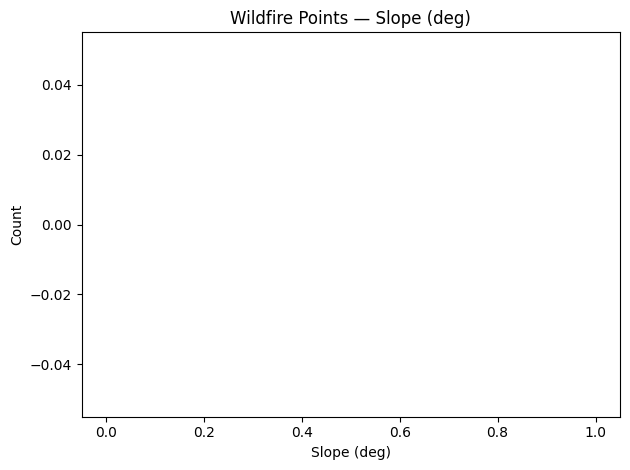

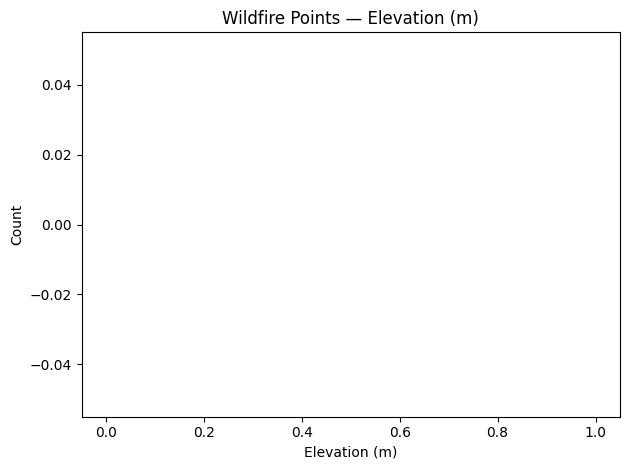

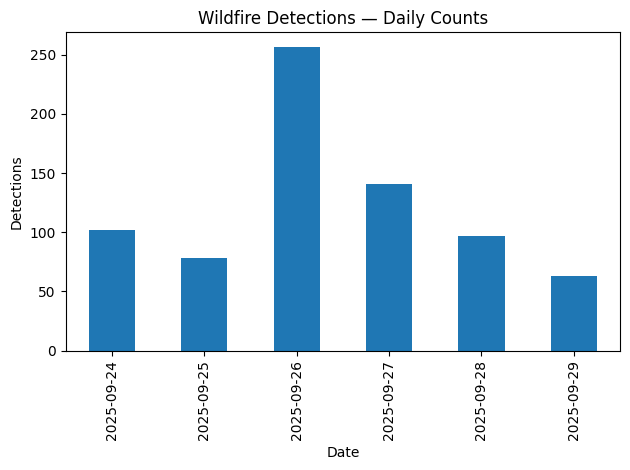

[Viz] Saved wildfire map → wildfire_points_map.html


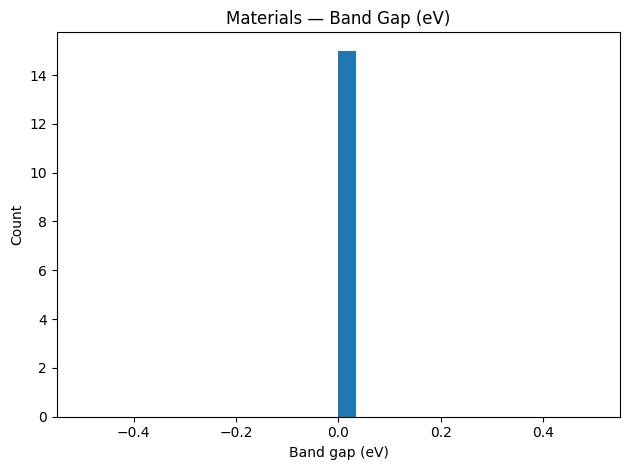

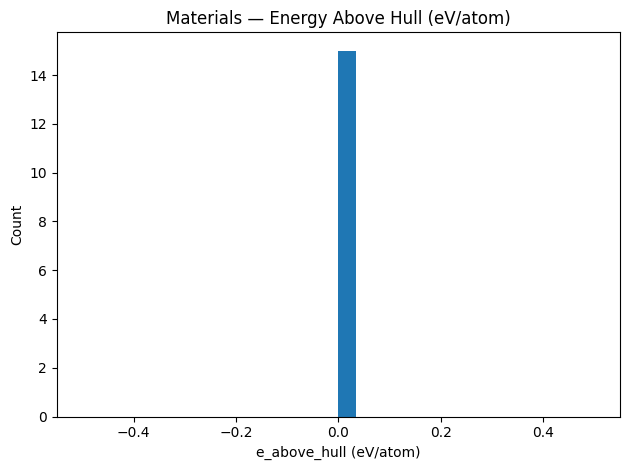

,material_id,formula,e_above_hull,band_gap,density
0,mp-862690,Ac1,0.0,0.0,8.170182
1,mp-1183076,Ac2 Ag1 Pb1,0.0,0.0,9.490476
2,mp-1183086,Ac2 Cd1 Hg1,0.0,0.0,9.570977
3,mp-862786,Ac2 Cu1 Ge1,0.0,0.0,8.598305
4,mp-861883,Ac2 Cu1 Ir1,0.0,0.0,11.322190
5,mp-867241,Ac2 Ge1 Pd1,0.0,0.0,9.154251
6,mp-861872,Ac2 Hg1 Ge1,0.0,0.0,9.670947
7,mp-1183377,Ac2 In1 Ga1,0.0,0.0,8.116507
8,mp-865951,Ac2 Ir1 Au1,0.0,0.0,12.810760
9,mp-866107,Ac2 Ir1 Pd1,0.0,0.0,11.927066


[Viz] Saved materials charts and top10 CSV.


In [85]:
# ==== Cell 5.3 — Quick Visual Diagnostics (Wildfire & Materials) ====
from __future__ import annotations
import os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional mapping
try:
    import folium
except Exception:
    folium = None

PROJECT_ROOT  = globals().get("PROJECT_ROOT", Path.cwd())
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
REPORTS_DIR   = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

WF_REGION = os.getenv("WF_REGION", "ES")
DATE_FROM = os.getenv("WF_DATE_FROM", globals().get("DATE_FROM", "unknownfrom"))
DATE_TO   = os.getenv("WF_DATE_TO",   globals().get("DATE_TO", "unknownto"))

# ---- Load wildfire terrain-enriched parquet (from Cell 7 output) ----
fires_parquet = PROCESSED_DIR / f"fires_terrain_{WF_REGION}_{DATE_FROM}_{DATE_TO}.parquet"
if not fires_parquet.exists():
    cand = sorted(PROCESSED_DIR.glob("fires_terrain_*.parquet"))
    fires_parquet = cand[-1] if cand else None

df_f = pd.read_parquet(fires_parquet) if fires_parquet and fires_parquet.exists() else pd.DataFrame()

# ---- Load materials candidates (from Cell 5.2) ----
mat_csv = REPORTS_DIR / "materials_candidates.csv"
df_m = pd.read_csv(mat_csv) if mat_csv.exists() else pd.DataFrame()

# ---------------- Wildfire Charts ----------------
if not df_f.empty:
    # Slope histogram
    if "slope_deg" in df_f.columns:
        plt.figure()
        df_f["slope_deg"].dropna().clip(0, 60).plot.hist(bins=30)
        plt.title("Wildfire Points — Slope (deg)")
        plt.xlabel("Slope (deg)"); plt.ylabel("Count")
        slope_png = REPORTS_DIR / "wildfire_slope_hist.png"
        plt.tight_layout(); plt.savefig(slope_png, dpi=180); plt.show()

    # Elevation histogram
    if "elevation_m" in df_f.columns:
        plt.figure()
        clip_to = np.nanpercentile(df_f["elevation_m"].astype(float), 99) if df_f["elevation_m"].notna().any() else 0
        df_f["elevation_m"].dropna().clip(0, clip_to).plot.hist(bins=30)
        plt.title("Wildfire Points — Elevation (m)")
        plt.xlabel("Elevation (m)"); plt.ylabel("Count")
        elev_png = REPORTS_DIR / "wildfire_elevation_hist.png"
        plt.tight_layout(); plt.savefig(elev_png, dpi=180); plt.show()

    # Daily density bar
    if "datetime" in df_f.columns and df_f["datetime"].notna().any():
        tmp = df_f.copy()
        tmp["date"] = pd.to_datetime(tmp["datetime"], errors="coerce", utc=True).dt.date
        dcounts = tmp.groupby("date").size()
        if len(dcounts) > 0:
            plt.figure()
            dcounts.plot(kind="bar")
            plt.title("Wildfire Detections — Daily Counts")
            plt.xlabel("Date"); plt.ylabel("Detections")
            dens_png = REPORTS_DIR / "wildfire_daily_density.png"
            plt.tight_layout(); plt.savefig(dens_png, dpi=180); plt.show()

    # Folium map (optional)
    if folium is not None and {"lat","lon"}.issubset(df_f.columns) and len(df_f) > 0:
        center = [float(df_f["lat"].dropna().mean()), float(df_f["lon"].dropna().mean())]
        m = folium.Map(location=center, zoom_start=6, tiles="cartodbpositron")
        # Sample at most 2000 points for performance
        sample = df_f[["lat","lon"]].dropna().sample(min(2000, len(df_f)), random_state=42)
        for _, r in sample.iterrows():
            folium.CircleMarker(location=[r["lat"], r["lon"]], radius=2, opacity=0.8, fill=True).add_to(m)
        fmap = REPORTS_DIR / "wildfire_points_map.html"
        m.save(str(fmap))
        print(f"[Viz] Saved wildfire map → {fmap.name}")
else:
    print("[Viz] No wildfire parquet found. Run GeoTerrainAgent first.")

# ---------------- Materials Charts ----------------
if not df_m.empty:
    # Sanitize numeric columns
    for c in ("band_gap", "e_above_hull", "density"):
        if c in df_m.columns:
            df_m[c] = pd.to_numeric(df_m[c], errors="coerce")

    # Band gap histogram
    if "band_gap" in df_m.columns and df_m["band_gap"].notna().any():
        plt.figure()
        df_m["band_gap"].dropna().clip(0, 6).plot.hist(bins=30)
        plt.title("Materials — Band Gap (eV)")
        plt.xlabel("Band gap (eV)"); plt.ylabel("Count")
        bg_png = REPORTS_DIR / "materials_bandgap_hist.png"
        plt.tight_layout(); plt.savefig(bg_png, dpi=180); plt.show()

    # Energy above hull histogram
    if "e_above_hull" in df_m.columns and df_m["e_above_hull"].notna().any():
        plt.figure()
        df_m["e_above_hull"].dropna().clip(0, 0.3).plot.hist(bins=30)
        plt.title("Materials — Energy Above Hull (eV/atom)")
        plt.xlabel("e_above_hull (eV/atom)"); plt.ylabel("Count")
        eah_png = REPORTS_DIR / "materials_eah_hist.png"
        plt.tight_layout(); plt.savefig(eah_png, dpi=180); plt.show()

    # Top 10 table (lowest e_above_hull first, then band_gap)
    sort_cols = [c for c in ["e_above_hull","band_gap"] if c in df_m.columns]
    cols = [c for c in ["material_id","formula","e_above_hull","band_gap","density"] if c in df_m.columns]
    if sort_cols and cols:
        top10 = df_m.sort_values(by=sort_cols, na_position="last").head(10)[cols]
        display(top10)
        top10.to_csv(REPORTS_DIR / "materials_top10.csv", index=False)
        print("[Viz] Saved materials charts and top10 CSV.")
else:
    # Read status to help understand if MP was skipped
    mj = REPORTS_DIR / "materials_recommendation.json"
    if mj.exists():
        try:
            status = json.loads(mj.read_text(encoding="utf-8")).get("status", "unknown")
            print(f"[Viz] No materials CSV found. materials_recommendation status = {status}.")
        except Exception:
            print("[Viz] No materials CSV found and could not parse materials_recommendation.json")
    else:
        print("[Viz] No materials artifacts found. Ensure Cell 5.1/5.2 ran successfully.")


## Cell 6 – Unified Source Configuration
Defines all external data sources for fires, weather, climate, hydrology, and terrain.  
Centralized registry ensures consistency, reproducibility, and easy updates across the pipeline.

In [86]:
# ==== WildfiresAI — Cell 6: Unified Source Configuration ====
# Sources are declared here and controlled via environment variables when required.

# ---- Fire sources ----
SRC_FIRES = {
    "FIRMS": {
        "enabled": True,
        "endpoint": os.getenv("FIRMS_CSV_URL", ""),
        "token": os.getenv("FIRMS_TOKEN", ""),
        "map_key": os.getenv("FIRMS_MAP_KEY", ""),
        "notes": "Global near real-time fire detections (VIIRS/MODIS)."
    },
    "EFFIS": {
        "enabled": True,
        "wfs_url": os.getenv("EFFIS_WFS_URL", ""),
        "notes": "Europe fire perimeters and burned area (via Copernicus Emergency)."
    },
    "NIFC": {
        "enabled": True,
        "featureserver_url": os.getenv("NIFC_FEATURESERVER_URL", ""),
        "notes": "United States wildfire perimeters/incidents (NIFC FeatureServer)."
    },
}

# ---- Weather & climate (via Open-Meteo) ----
SRC_WEATHER = {
    "OPEN_METEO_FORECAST": {
        "enabled": True,
        "base_url": "https://api.open-meteo.com/v1/forecast",
        "hourly": [
            "temperature_2m", "relative_humidity_2m", "windspeed_10m",
            "winddirection_10m", "windgusts_10m", "dew_point_2m",
            "precipitation", "surface_pressure"
        ],
        "models": os.getenv("OM_MODELS", "gfs_seamless"),
        "notes": "Global short-term forecast (GFS-backed when models=gfs_*)."
    },
    "OPEN_METEO_ARCHIVE": {
        "enabled": True,
        "base_url": "https://archive-api.open-meteo.com/v1/archive",
        "hourly": [
            "temperature_2m", "relative_humidity_2m", "windspeed_10m",
            "winddirection_10m", "dew_point_2m", "precipitation",
            "surface_pressure"
        ],
        "notes": "Historical archive (ERA5-backed hourly data)."
    },
    "ERA5_ALIAS": {"enabled": True, "notes": "Handled via OPEN_METEO_ARCHIVE."},
    "GFS_ALIAS": {"enabled": True, "notes": "Handled via OPEN_METEO_FORECAST."},
}

# ---- Hydrology / drought ----
SRC_HYDRO = {
    "GRACE": {
        "enabled": True,
        "url": os.getenv("GRACE_URL", ""),
        "earthdata_user": os.getenv("EARTHDATA_USERNAME", ""),
        "earthdata_pass": os.getenv("EARTHDATA_PASSWORD", ""),
        "notes": "Groundwater/drought indicators (NASA GRACE)."
    }
}

# ---- Terrain & land cover ----
SRC_TERRAIN = {
    "GLOBAL_BASELINE": {
        "enabled": True,
        "dem": "Copernicus DEM GLO-30",
        "landcover": "ESA WorldCover 10m",
        "notes": "Global baseline terrain and land cover."
    },
    "EUROPE": {
        "enabled": True,
        "dem": "EU-DEM 25m",
        "landcover": "CORINE Land Cover",
        "notes": "European terrain and land cover products."
    },
    "USA": {
        "enabled": True,
        "dem": "USGS 3DEP 1m",
        "notes": "High-resolution DEM for the United States."
    },
}

# ---- Region windows (BBOX) ----
REGION_CFG = {
    "ES": {"bbox": (-9.5, 35.0, 3.5, 43.9)},        # Spain
    "US": {"bbox": (-125.0, 24.4, -66.9, 49.4)},    # Conterminous US
    "EU": {"bbox": (-25.0, 34.0, 45.0, 72.0)},      # Europe
}
ACTIVE_BBOX = REGION_CFG.get(WF_REGION, REGION_CFG["ES"])["bbox"]

# ---- Central registry ----
CFG_SOURCES = {
    "region": WF_REGION,
    "bbox": ACTIVE_BBOX,
    "window": {"from": DATE_FROM, "to": DATE_TO},
    "fires": SRC_FIRES,
    "weather": SRC_WEATHER,
    "hydrology": SRC_HYDRO,
    "terrain": SRC_TERRAIN,
}

# ---- Summary table ----
def summarize_sources(cfg: dict) -> pd.DataFrame:
    rows = []
    for group, entries in cfg.items():
        if isinstance(entries, dict):
            for name, meta in entries.items():
                if isinstance(meta, dict) and "enabled" in meta:
                    rows.append({
                        "group": group,
                        "name": name,
                        "enabled": meta["enabled"],
                        "detail": meta.get("notes", "")
                    })
    return pd.DataFrame(rows, columns=["group","name","enabled","detail"])

print("Active region:", CFG_SOURCES["region"], "| BBOX:", CFG_SOURCES["bbox"])
display(summarize_sources(CFG_SOURCES))

    

Active region: ES | BBOX: (-9.5, 35.0, 3.5, 43.9)


,group,name,enabled,detail
0,fires,FIRMS,True,Global near real-time fire detections (VIIRS/M...
1,fires,EFFIS,True,Europe fire perimeters and burned area (via Co...
2,fires,NIFC,True,United States wildfire perimeters/incidents (N...
3,weather,OPEN_METEO_FORECAST,True,Global short-term forecast (GFS-backed when mo...
4,weather,OPEN_METEO_ARCHIVE,True,Historical archive (ERA5-backed hourly data).
5,weather,ERA5_ALIAS,True,Handled via OPEN_METEO_ARCHIVE.
6,weather,GFS_ALIAS,True,Handled via OPEN_METEO_FORECAST.
7,hydrology,GRACE,True,Groundwater/drought indicators (NASA GRACE).
8,terrain,GLOBAL_BASELINE,True,Global baseline terrain and land cover.
9,terrain,EUROPE,True,European terrain and land cover products.


## Cell ? – IngestAgent (Fires, Weather, Hydrology)
Downloads and caches raw datasets: FIRMS, EFFIS (WFS), NIFC (FeatureServer), Open-Meteo (forecast/archive), and GRACE.
Outputs are stored under `data/raw/<source>/...` with a concise ingest report.


In [ ]:
## Cell 5 — IngestAgent (FIRMS + Weather + hooks EFFIS/NIFC)

import os, json, time
from pathlib import Path
from datetime import datetime, timezone
from typing import Optional, Dict, Any, Tuple

import pandas as pd
import requests
import structlog
from dotenv import load_dotenv

# --- env & paths
PROJECT_ROOT = Path.cwd()
RAW_DIR = PROJECT_ROOT / "data" / "raw"
REPORTS_DIR = PROJECT_ROOT / "reports"
RAW_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

load_dotenv()  # read .env once
log = structlog.get_logger("ingest").bind(region=os.getenv("WF_REGION", "ES"))

# --- config (from Cell 3 defaults)
SPAIN_BBOX = globals().get("SPAIN_BBOX", (-9.5, 35.0, 3.5, 43.9))
DATE_FROM = globals().get("DATE_FROM")
DATE_TO   = globals().get("DATE_TO")

# --- endpoints & keys
FIRMS_MAP_KEY  = os.getenv("FIRMS_MAP_KEY")
FIRMS_TOKEN    = os.getenv("FIRMS_TOKEN")          # optional (Bearer)
FIRMS_CSV_URL  = os.getenv("FIRMS_CSV_URL")        # required for CSV mode

EFFIS_WFS_URL  = os.getenv("EFFIS_WFS_URL")        # optional
NIFC_FS_URL    = os.getenv("NIFC_FS_URL")          # optional

def _bbox_dict(bbox: Tuple[float,float,float,float]) -> Dict[str, float]:
    w, s, e, n = bbox
    return {"west": w, "south": s, "east": e, "north": n}

def _save_json(obj: Any, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

artifacts = []

# --- 5.1 FIRMS (CSV mode with MAP_KEY) ---------------------------------
try:
    if not FIRMS_CSV_URL:
        log.warning("firms_endpoint_missing", hint="Set FIRMS_CSV_URL in env")
    else:
        from datetime import timezone
        dt_from = datetime.fromisoformat(str(DATE_FROM))
        dt_to   = datetime.fromisoformat(str(DATE_TO))
        window_days = max(1, min((dt_to - dt_from).days or 1, 10))

        # Compose URL directly with bbox and day inside the path
        w, s, e, n = SPAIN_BBOX
        url = f"{FIRMS_CSV_URL}/{w},{s},{e},{n}/{window_days}"

        r = requests.get(url, timeout=90)
        r.raise_for_status()

        ts = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
        out_csv = RAW_DIR / f"firms_viirs_snpp_{DATE_FROM}_{DATE_TO}_{ts}.csv"
        out_csv.write_text(r.text, encoding="utf-8")

        log.info("firms_csv_downloaded", path=str(out_csv))
        artifacts.append(("firms", str(out_csv)))

except Exception as e:
    log.warning("firms_download_failed", err=str(e))




# --- 5.2 Open-Meteo (archive + forecast) --------------------------------
try:
    W, S, E, N = SPAIN_BBOX
    lat_c, lon_c = (S + N) / 2.0, (W + E) / 2.0

    ts = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
    hourly_vars = [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "windspeed_10m", "windgusts_10m", "winddirection_10m",
        "precipitation", "surface_pressure"
    ]
    params_common = {
        "latitude": round(lat_c, 4),
        "longitude": round(lon_c, 4),
        "start_date": str(DATE_FROM),
        "end_date": str(DATE_TO),
        "hourly": ",".join(hourly_vars),
        "timezone": "UTC"
    }

    # Archive (ERA5-backed)
    om_archive = os.getenv("OM_ARCHIVE", "https://archive-api.open-meteo.com/v1/archive")
    r = requests.get(om_archive, params=params_common, timeout=90)
    r.raise_for_status()
    out_archive = RAW_DIR / "openmeteo_archive" / f"archive_{lat_c:.3f}_{lon_c:.3f}_{DATE_FROM}_{DATE_TO}_{ts}.json"
    out_archive.parent.mkdir(parents=True, exist_ok=True)
    _save_json(r.json(), out_archive)
    log.info("openmeteo_downloaded", label="archive", path=str(out_archive))
    artifacts.append(("om_archive", str(out_archive)))

    # Forecast (GFS-backed)
    om_forecast = os.getenv("OM_FORECAST", "https://api.open-meteo.com/v1/forecast")
    r2 = requests.get(om_forecast, params={**params_common, "models": "gfs_seamless"}, timeout=90)
    r2.raise_for_status()
    out_forecast = RAW_DIR / "openmeteo_forecast" / f"forecast_{lat_c:.3f}_{lon_c:.3f}_{DATE_FROM}_{DATE_TO}_{ts}.json"
    out_forecast.parent.mkdir(parents=True, exist_ok=True)
    _save_json(r2.json(), out_forecast)
    log.info("openmeteo_downloaded", label="forecast", path=str(out_forecast))
    artifacts.append(("om_forecast", str(out_forecast)))

except Exception as e:
    log.warning("openmeteo_failed", err=str(e))

# --- 5.3 EFFIS (optional; WFS) -----------------------------------------
try:
    effis_url = os.getenv("EFFIS_WFS_URL")
    effis_lyr = os.getenv("EFFIS_TYPENAME")
    if effis_url and effis_lyr:
        # Ejemplo de GetFeature WFS → GeoJSON
        w, s, e, n = SPAIN_BBOX
        params = {
            "service": "WFS",
            "request": "GetFeature",
            "version": "2.0.0",
            "typeNames": effis_lyr,             
            "srsName": "EPSG:4326",
            "bbox": f"{s},{w},{n},{e},EPSG:4326",
            "outputFormat": "application/json"
        }
        r = requests.get(effis_url, params=params, timeout=120)
        r.raise_for_status()
        out_effis = RAW_DIR / "effis" / f"perimeters_{DATE_FROM}_{DATE_TO}_{ts}.geojson"
        out_effis.parent.mkdir(parents=True, exist_ok=True)
        _save_json(r.json(), out_effis)
        log.info("effis_geojson_downloaded", path=str(out_effis))
        artifacts.append(("effis_perimeters", str(out_effis)))
    # Sin URL/typename → silencio (no “skipped”) hasta que tengas acceso oficial.

except Exception as e:
    log.warning("effis_failed", err=str(e))


# --- 5.4 NIFC (USA perimeters; ArcGIS FeatureServer → GeoJSON) ---------
try:
    # Usamos un valor por defecto robusto si la var no está (vista "Current").
    nifc_url = os.getenv(
        "NIFC_FS_URL",
        "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters_Current/FeatureServer/0"
    )

    if nifc_url:
       
        w, s, e, n = SPAIN_BBOX  # puedes usar otra bbox según región
        geometry = {
            "xmin": w, "ymin": s, "xmax": e, "ymax": n,
            "spatialReference": {"wkid": 4326}
        }
        q = {
            "where": "1=1",
            "geometryType": "esriGeometryEnvelope",
            "geometry": json.dumps(geometry),
            "inSR": 4326,
            "spatialRel": "esriSpatialRelIntersects",
            "outFields": "*",
            "returnGeometry": "true",
            "f": "geojson"  # salida directa GeoJSON
        }
        r = requests.get(f"{nifc_url}/query", params=q, timeout=120)
        r.raise_for_status()
        gj = r.json()

        out_nifc = RAW_DIR / "nifc" / f"perimeters_{DATE_FROM}_{DATE_TO}_{ts}.geojson"
        out_nifc.parent.mkdir(parents=True, exist_ok=True)
        _save_json(gj, out_nifc)
        log.info("nifc_geojson_downloaded", path=str(out_nifc))
        artifacts.append(("nifc_perimeters", str(out_nifc)))
   

except Exception as e:
    log.warning("nifc_failed", err=str(e))


# --- 5.5 Report ---------------------------------------------------------
ingest_report = REPORTS_DIR / f"ingest_report_{os.getenv('WF_REGION','ES')}_{DATE_FROM}_{DATE_TO}.json"
_save_json({"artifacts": artifacts}, ingest_report)
print(f"Ingest report: {ingest_report}")

# Display a compact table
pd.DataFrame(artifacts, columns=["source","artifact"])





## Cell ? – CleanerAgent (Robust Normalization)
Normalize raw inputs into consistent, typed tables ready for terrain enrichment and spatiotemporal joins.

**Outputs**
- `data/processed/fires_clean.parquet`
- `data/processed/effis_clean.parquet` (if available)
- `data/processed/nifc_clean.parquet` (if available)
- `data/processed/weather_points.parquet`
- `reports/clean_report.json`

In [ ]:
## Cell 6 — CleanerAgent (FIRMS + Open-Meteo + NIFC; robust validation & sampling)

import os, json
from pathlib import Path
import pandas as pd

# Paths from earlier cells
PROC_DIR = PROJECT_ROOT / "data" / "processed"
RAW_DIR = PROJECT_ROOT / "data" / "raw"
REPORTS_DIR = PROJECT_ROOT / "reports"
for p in (PROC_DIR, RAW_DIR, REPORTS_DIR):
    p.mkdir(parents=True, exist_ok=True)

clean_artifacts: list[tuple[str,str]] = []

# ---------------- Helpers ----------------

def _save_report(obj: dict, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def _sniff_sep(path: Path) -> str:
    # Delimiter sniffer between comma and semicolon
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        sample = f.read(4096)
    return "," if sample.count(",") >= sample.count(";") else ";"

def _find_col(colmap_lower: dict[str,str], candidates: list[str]) -> str | None:
    # Return original-case column name for the first lower-cased match
    for c in candidates:
        if c in colmap_lower:
            return colmap_lower[c]
    return None

def _build_datetime(df: pd.DataFrame, date_col: str | None, time_col: str | None, dt_col: str | None) -> pd.Series:
    # Build timezone-aware timestamp (UTC). If missing parts, coerce to NaT.
    if dt_col and dt_col in df.columns:
        return pd.to_datetime(df[dt_col], errors="coerce", utc=True)
    if date_col and time_col and date_col in df.columns and time_col in df.columns:
        t = df[time_col].astype(str).str.zfill(4)
        return pd.to_datetime(
            df[date_col].astype(str) + " " + t.str[:2] + ":" + t.str[2:4] + ":00",
            errors="coerce", utc=True
        )
    if date_col and date_col in df.columns:
        return pd.to_datetime(df[date_col], errors="coerce", utc=True)
    return pd.to_datetime(pd.NaT)

# ---------------- 6.1 Clean FIRMS (CSV) ----------------

try:
    firms_raw = sorted(RAW_DIR.glob("firms_viirs_snpp_*.csv"))
    if not firms_raw:
        log.warning("clean_firms_missing", hint="No FIRMS CSV found in data/raw/")
    else:
        latest = firms_raw[-1]
        sep = _sniff_sep(latest)

        df_firms = pd.read_csv(latest, sep=sep, engine="python", dtype={"acq_time": "string"})
        df_firms.columns = [c.strip() for c in df_firms.columns]
        colmap_lower = {c.lower(): c for c in df_firms.columns}

        lat_col = _find_col(colmap_lower, ["latitude", "lat", "y", "latitud"])
        lon_col = _find_col(colmap_lower, ["longitude", "lon", "x", "longitud", "long"])
        if not lat_col or not lon_col:
            raise KeyError("FIRMS CSV lacks latitude/longitude columns (tried latitude|lat|y and longitude|lon|x variants)")

        dt_col   = _find_col(colmap_lower, ["acq_datetime", "datetime", "time_utc"])
        date_col = _find_col(colmap_lower, ["acq_date", "date", "fecha"])
        time_col = _find_col(colmap_lower, ["acq_time", "time", "hora"])

        out = pd.DataFrame({
            "lat":  pd.to_numeric(df_firms[lat_col], errors="coerce"),
            "lon":  pd.to_numeric(df_firms[lon_col], errors="coerce"),
            "datetime": _build_datetime(df_firms, date_col, time_col, dt_col),
            "brightness": pd.to_numeric(df_firms[_find_col(colmap_lower, ["brightness", "bright_ti4", "bright_ti5"])], errors="coerce") if _find_col(colmap_lower, ["brightness","bright_ti4","bright_ti5"]) else pd.NA,
            "confidence": pd.to_numeric(df_firms[_find_col(colmap_lower, ["confidence"])], errors="coerce") if _find_col(colmap_lower, ["confidence"]) else pd.NA,
            "frp": pd.to_numeric(df_firms[_find_col(colmap_lower, ["frp"])], errors="coerce") if _find_col(colmap_lower, ["frp"]) else pd.NA,
            "satellite": df_firms[_find_col(colmap_lower, ["satellite"])] if _find_col(colmap_lower, ["satellite"]) else pd.NA,
            "source": "FIRMS"
        })

        out = out.dropna(subset=["lat", "lon"]).drop_duplicates(subset=["datetime","lat","lon"]).reset_index(drop=True)

        ACTIVE_BBOX = globals().get("ACTIVE_BBOX", globals().get("SPAIN_BBOX"))
        if ACTIVE_BBOX is not None:
            w, s, e, n = ACTIVE_BBOX
            out = out[(out["lon"].between(w, e)) & (out["lat"].between(s, n))].copy()

        if "DATE_FROM" in globals() and "DATE_TO" in globals() and "datetime" in out.columns:
            out = out[(out["datetime"] >= pd.to_datetime(DATE_FROM, utc=True)) &
                      (out["datetime"] <= pd.to_datetime(DATE_TO,   utc=True))].copy()

        region = os.getenv("WF_REGION", "ES")
        out_firms = PROC_DIR / f"firms_clean_{region}_{DATE_FROM}_{DATE_TO}.csv"
        out.to_csv(out_firms, index=False)
        log.info("firms_clean_saved", rows=len(out), path=str(out_firms))

        sample_firms = REPORTS_DIR / f"sample_firms_{region}_{DATE_FROM}_{DATE_TO}.json"
        out.head(10).to_json(sample_firms, orient="records", indent=2)
        clean_artifacts.append(("fires", str(out_firms)))

except Exception as e:
    log.warning("clean_firms_fail", err=str(e))

# ---------------- 6.2 Clean Open-Meteo (archive JSON → parquet) ----------------

try:
    wx_archives = sorted((RAW_DIR / "openmeteo_archive").glob("archive_*.json"))
    if not wx_archives:
        log.warning("clean_weather_missing", hint="No Open-Meteo archive found")
    else:
        js = json.load(open(wx_archives[-1], encoding="utf-8"))
        hourly = js.get("hourly", {})
        df_wx = pd.DataFrame(hourly)

        if "time" in df_wx.columns:
            df_wx["datetime"] = pd.to_datetime(df_wx["time"], errors="coerce", utc=True)

        out_wx = PROC_DIR / "weather_points.parquet"
        df_wx.to_parquet(out_wx, index=False)
        log.info("weather_points_saved", rows=len(df_wx), path=str(out_wx))

        sample_wx = REPORTS_DIR / f"sample_weather_{os.getenv('WF_REGION','ES')}_{DATE_FROM}_{DATE_TO}.json"
        df_wx.head(10).to_json(sample_wx, orient="records", indent=2)
        clean_artifacts.append(("weather_points", str(out_wx)))
except Exception as e:
    log.warning("clean_weather_fail", err=str(e))

# ---------------- 6.3 Clean NIFC (GeoJSON perimeters → centroid points) ----------------
try:
    nifc_files = sorted((RAW_DIR / "nifc").glob("perimeters_*.geojson"))
    if nifc_files:
        latest_nifc = nifc_files[-1]

        # Prefer geopandas if available; otherwise use a robust JSON fallback
        try:
            import geopandas as gpd  # guarded import (no duplicate global imports)
            gdf = gpd.read_file(latest_nifc)

            # Ensure we start in geographic CRS for bbox filtering and then project to metric CRS
            try:
                gdf = gdf.to_crs(4326)
            except Exception:
                pass

            # Compute centroids in a metric CRS for accuracy, then convert back to WGS84
            try:
                gdf_3857 = gdf.to_crs(3857)
                cent_m = gdf_3857.geometry.centroid
                cent_wgs84 = cent_m.to_crs(4326)
                df_nifc = pd.DataFrame({"lon": cent_wgs84.x, "lat": cent_wgs84.y})
            except Exception:
                # Fallback if reprojection fails for some geometries
                cent_wgs84 = gdf.to_crs(4326).geometry.centroid
                df_nifc = pd.DataFrame({"lon": cent_wgs84.x, "lat": cent_wgs84.y})

            # Try to extract a perimeter datetime from attributes if present
            props = gdf.drop(columns=["geometry"], errors="ignore")
            time_cols = [c for c in props.columns if any(k in c.lower() for k in ["date", "time", "datetime", "perimeter"])]
            if time_cols:
                df_nifc["datetime"] = pd.to_datetime(props[time_cols[0]], errors="coerce", utc=True)
            else:
                df_nifc["datetime"] = pd.NaT

            df_nifc["source"] = "NIFC"

        except Exception:
            # JSON fallback: compute crude centroid (mean of ring vertices) per feature
            js = json.load(open(latest_nifc, encoding="utf-8"))
            feats = js.get("features", [])
            rows = []
            for f in feats:
                geom = f.get("geometry", {})
                coords = []
                if geom.get("type") == "Polygon":
                    for ring in geom.get("coordinates", []):
                        coords.extend(ring)
                elif geom.get("type") == "MultiPolygon":
                    for poly in geom.get("coordinates", []):
                        for ring in poly:
                            coords.extend(ring)
                if coords:
                    xs = [float(x) for x, y in coords]
                    ys = [float(y) for x, y in coords]
                    lon = sum(xs) / len(xs)
                    lat = sum(ys) / len(ys)
                    props = f.get("properties", {})
                    tfield = next((k for k in props.keys() if any(s in k.lower() for s in ["date","time","datetime","perimeter"])), None)
                    dt = pd.to_datetime(props.get(tfield), errors="coerce", utc=True) if tfield else pd.NaT
                    rows.append({"lon": lon, "lat": lat, "datetime": dt, "source": "NIFC"})
            df_nifc = pd.DataFrame(rows)

        # Optional spatial and temporal filters based on globals
        ACTIVE_BBOX = globals().get("ACTIVE_BBOX", globals().get("SPAIN_BBOX"))
        if ACTIVE_BBOX is not None and not df_nifc.empty:
            w, s, e, n = ACTIVE_BBOX
            df_nifc = df_nifc[(df_nifc["lon"].between(w, e)) & (df_nifc["lat"].between(s, n))].copy()

        if "DATE_FROM" in globals() and "DATE_TO" in globals() and not df_nifc.empty and "datetime" in df_nifc.columns:
            df_nifc = df_nifc[(df_nifc["datetime"].isna()) |
                              ((df_nifc["datetime"] >= pd.to_datetime(DATE_FROM, utc=True)) &
                               (df_nifc["datetime"] <= pd.to_datetime(DATE_TO,   utc=True)))]

        out_nifc = PROC_DIR / f"nifc_clean_{os.getenv('WF_REGION','ES')}_{DATE_FROM}_{DATE_TO}.parquet"
        if not df_nifc.empty:
            df_nifc.to_parquet(out_nifc, index=False)
            log.info("nifc_clean_saved", rows=len(df_nifc), path=str(out_nifc))
            clean_artifacts.append(("nifc_clean", str(out_nifc)))
        else:
            log.info("nifc_clean_empty")
    # If no NIFC file present, keep silent (clean pipeline)

except Exception as e:
    log.warning("clean_nifc_fail", err=str(e))

# ---------------- 6.4 Report ----------------

clean_report = REPORTS_DIR / f"clean_report_{os.getenv('WF_REGION','ES')}_{DATE_FROM}_{DATE_TO}.json"
_save_report({"artifacts": clean_artifacts}, clean_report)
print(f"Clean report: {clean_report}")

pd.DataFrame(clean_artifacts, columns=["artifact","value"])


## Cell ? — GeoTerrainAgent (terrain enrichment with auto-fetch)
Enrich fire detections with terrain attributes: elevation, slope, and land cover.
- DEM: OpenTopography (requires OPENTOPO_API_KEY in .env)
- Land cover: ESA WorldCover (via Planetary Computer STAC, fallback years)
 Output: terrain-enriched fires saved to Parquet.


In [ ]:
## Cell 7 — GeoTerrainAgent (terrain enrichment with auto-fetch, memory-safe)

from pathlib import Path
import os, json, math
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import Affine
import structlog

log = structlog.get_logger("geoterrain").bind(region=os.getenv("WF_REGION", "ES"))

# --- config / paths
REGION = os.getenv("WF_REGION", "ES")
W, S, E, N = globals().get("ACTIVE_BBOX", globals().get("SPAIN_BBOX", (-9.5, 35.0, 3.5, 43.9)))

TERRAIN_DIR = PROJECT_ROOT / "data" / "terrain"
TERRAIN_DIR.mkdir(parents=True, exist_ok=True)
DEM_TIF = TERRAIN_DIR / "copernicus_dem.tif"
LC_TIF  = TERRAIN_DIR / "esa_worldcover_clip.tif"

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
fires_clean_path   = PROCESSED_DIR / f"firms_clean_{REGION}_{DATE_FROM}_{DATE_TO}.csv"
fires_terrain_out  = PROCESSED_DIR / f"fires_terrain_{REGION}_{DATE_FROM}_{DATE_TO}.parquet"

# ----------------------- helpers: asset download/build -----------------------

def _download_dem_opentopo(w: float, s: float, e: float, n: float, out_path: Path, demtype="SRTMGL3") -> None:
    """
    Fetch DEM GeoTIFF clipped to bbox using OpenTopography Global DEM API (SRTMGL3).
    Requires OPENTOPO_API_KEY in .env.
    """
    import requests
    api_key = os.getenv("OPENTOPO_API_KEY", "")
    url = "https://portal.opentopography.org/API/globaldem"
    params = {
        "demtype": demtype,
        "south": s, "north": n, "west": w, "east": e,
        "outputFormat": "GTiff",
        "API_Key": api_key
    }
    r = requests.get(url, params=params, timeout=600); r.raise_for_status()
    try:
        js = r.json()
        tif_url = None
        if isinstance(js, dict) and "result" in js and "links" in js["result"]:
            for lnk in js["result"]["links"]:
                href = lnk.get("href", "")
                if href.endswith(".tif"):
                    tif_url = href
                    break
        if not tif_url:
            raise RuntimeError("No GeoTIFF link found in OpenTopography response.")
        r2 = requests.get(tif_url, timeout=1200); r2.raise_for_status()
        out_path.write_bytes(r2.content)
        log.info("dem_downloaded", src=tif_url, path=str(out_path))
    except Exception:
        out_path.write_bytes(r.content)
        log.info("dem_downloaded_direct", bytes=len(r.content), path=str(out_path))

def _build_worldcover_from_stac(w: float, s: float, e: float, n: float, out_path: Path) -> None:
    """
    Query ESA WorldCover via Planetary Computer STAC, clip to bbox, and save to GeoTIFF.
    Reads only the bounding window instead of entire mosaics (memory-safe).
    """
    from pystac_client import Client
    import planetary_computer as pc
    import rasterio
    from rasterio.windows import from_bounds

    stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    bbox = [w, s, e, n]
    years = [2021, 2020]
    items = []
    last_err = None

    for yr in years:
        try:
            search = stac.search(
                collections=["esa-worldcover"],
                bbox=bbox,
                datetime=f"{yr}-01-01/{yr}-12-31"
            )
            items = list(search.items())
            if items:
                log.info("worldcover_found", year=yr, count=len(items))
                break
        except Exception as ex:
            last_err = ex
            continue

    if not items:
        raise RuntimeError(f"No WorldCover found for bbox in years={years}. Last error: {last_err}")

    for it in items:
        asset = it.assets.get("map") or it.assets.get("Map")
        if not asset:
            continue
        signed_href = pc.sign(asset.href)
        with rasterio.open(signed_href) as src:
            window = from_bounds(w, s, e, n, src.transform)
            data = src.read(1, window=window)
            transform = src.window_transform(window)

            profile = src.profile.copy()
            profile.update({
                "driver": "GTiff",
                "height": data.shape[0],
                "width": data.shape[1],
                "transform": transform,
                "count": 1,
                "dtype": data.dtype,
                "compress": "lzw"
            })

            out_path.parent.mkdir(parents=True, exist_ok=True)
            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(data, 1)
            log.info("landcover_clipped", path=str(out_path), shape=data.shape)
            return

    raise RuntimeError("WorldCover items found but no usable 'map' assets.")

# ----------------------- ensure assets exist -----------------------

try:
    if not DEM_TIF.exists() or DEM_TIF.stat().st_size < 100_000:
        _download_dem_opentopo(W, S, E, N, DEM_TIF)
    else:
        log.info("dem_present", path=str(DEM_TIF), size=DEM_TIF.stat().st_size)
except Exception as e:
    log.warning("dem_unavailable", err=str(e))

try:
    if not LC_TIF.exists() or LC_TIF.stat().st_size < 100_000:
        _build_worldcover_from_stac(W, S, E, N, LC_TIF)
    else:
        log.info("landcover_present", path=str(LC_TIF), size=LC_TIF.stat().st_size)
except Exception as e:
    log.warning("landcover_unavailable", err=str(e))

# ----------------------- load fires & sampling -----------------------

try:
    df_fires = pd.read_csv(fires_clean_path)
    gdf_fires = gpd.GeoDataFrame(df_fires, geometry=gpd.points_from_xy(df_fires.lon, df_fires.lat), crs="EPSG:4326")
except Exception as e:
    log.error("fires_load_failed", err=str(e))
    gdf_fires = gpd.GeoDataFrame(columns=["lat","lon","geometry"], crs="EPSG:4326")

def _meters_per_degree(lat_deg: float) -> tuple[float, float]:
    lat_rad = math.radians(lat_deg)
    mx = 111_320.0 * math.cos(lat_rad)
    my = 110_540.0
    return mx, my

def _sample_dem_and_slope(dem_path: Path, gdf: gpd.GeoDataFrame) -> tuple[list[float], list[float]]:
    elevs, slopes = [], []
    try:
        with rasterio.open(dem_path) as src:
            tr: Affine = src.transform
            band1 = src.read(1, masked=True)
            deg_based = abs(tr.a) < 1e-2 and abs(tr.e) < 1e-2
            for pt in gdf.geometry:
                if pt is None or pt.is_empty:
                    elevs.append(np.nan); slopes.append(np.nan); continue
                col, row = src.index(pt.x, pt.y)
                if 0 <= row < src.height and 0 <= col < src.width:
                    z = band1[row, col]
                    z = float(z) if z is not np.ma.masked else np.nan
                else:
                    z = np.nan
                r0, r1 = max(row-1, 0), min(row+2, src.height)
                c0, c1 = max(col-1, 0), min(col+2, src.width)
                patch = band1[r0:r1, c0:c1]
                slope_deg = np.nan
                if patch.shape == (3,3) and np.all(~patch.mask):
                    if deg_based:
                        mx, my = _meters_per_degree(pt.y)
                        px = abs(tr.a) * mx; py = abs(tr.e) * my
                    else:
                        px = abs(tr.a); py = abs(tr.e) if abs(tr.e) > 0 else abs(tr.d)
                    p = patch.filled(np.nan).astype(float)
                    dzdx = ((p[0,2] + 2*p[1,2] + p[2,2]) - (p[0,0] + 2*p[1,0] + p[2,0])) / (8.0 * px)
                    dzdy = ((p[2,0] + 2*p[2,1] + p[2,2]) - (p[0,0] + 2*p[0,1] + p[0,2])) / (8.0 * py)
                    slope_rad = math.atan(math.hypot(dzdx, dzdy))
                    slope_deg = math.degrees(slope_rad)
                elevs.append(z); slopes.append(slope_deg)
        log.info("dem_sampled", count=len(elevs))
    except Exception as e:
        log.warning("dem_sample_failed", err=str(e))
        elevs = [np.nan] * len(gdf); slopes = [np.nan] * len(gdf)
    return elevs, slopes

def _sample_categorical(raster_path: Path, gdf: gpd.GeoDataFrame) -> list[float]:
    vals: list[float] = []
    try:
        with rasterio.open(raster_path) as src:
            for pt in gdf.geometry:
                if pt is None or pt.is_empty:
                    vals.append(np.nan); continue
                val = list(src.sample([(pt.x, pt.y)]))[0][0]
                if src.nodata is not None and val == src.nodata:
                    vals.append(np.nan)
                else:
                    try: vals.append(int(val))
                    except Exception: vals.append(float(val))
        log.info("landcover_sampled", count=len(vals))
    except Exception as e:
        log.warning("landcover_sample_failed", err=str(e))
        vals = [np.nan] * len(gdf)
    return vals

# --- enrich fires with elevation, slope, land cover ---
try:
    elev, slope = _sample_dem_and_slope(DEM_TIF, gdf_fires)
    gdf_fires["elevation_m"]  = elev
    gdf_fires["slope_deg"]    = slope
    gdf_fires["land_cover_code"] = _sample_categorical(LC_TIF, gdf_fires)

    gdf_fires.drop(columns=["geometry"]).to_parquet(fires_terrain_out, index=False)
    log.info("fires_terrain_saved", path=str(fires_terrain_out), rows=len(gdf_fires))
    print(f"Terrain-enriched fires saved: {fires_terrain_out}")
except Exception as e:
    log.error("fires_terrain_failed", err=str(e))
    raise


## Cell 10 — Open-Meteo Helper (Hourly, ERA5 Archive)

This cell defines a reusable **helper function** to query the [Open-Meteo Archive API](https://open-meteo.com/en/docs/historical-weather-api) for historical weather data based on the **ERA5 reanalysis dataset**. No API key is required.  

**Main features:**

1. **Endpoint & Variables**  
   - Uses the ERA5 archive endpoint (`https://archive-api.open-meteo.com/v1/archive`).  
   - Retrieves hourly variables relevant to wildfire dynamics (temperature, humidity, wind, precipitation, and surface pressure).  

2. **Function `fetch_open_meteo`**  
   - Inputs: latitude, longitude, start date, end date, and selected variables.  
   - Returns a **Pandas DataFrame** with hourly weather records in UTC.  
   - Columns include `time_utc`, meteorological variables, and coordinates (`lat`, `lon`).  

3. **Error Handling & Validation**  
   - Raises explicit errors if the API response is invalid (e.g., missing hourly data).  
   - Ensures numeric casting of meteorological fields for consistent analysis.  

4. **Persistence**  
   - Provides a lightweight `save_df` utility to persist datasets under the `data/raw/` folder.  
   - Facilitates traceability and reproducibility of weather datasets.  

This component is critical for aligning **FIRMS fire detections** with **meteorological context**, enabling joint analyses (e.g., fire spread vs. weather dynamics) and subsequent model training.



In [ ]:
from typing import Iterable

# Endpoint correcto para histórico/reanálisis (ERA5):
OPEN_METEO_BASE = "https://archive-api.open-meteo.com/v1/archive"

# Variables horarias por defecto (puedes añadir/quitar)
OPEN_METEO_HOURLY = [
    "temperature_2m",
    "relative_humidity_2m",
    "dew_point_2m",
    "windspeed_10m",
    "windgusts_10m",
    "winddirection_10m",
    "precipitation",
    "surface_pressure",
]

# Pequeño helper local por si save_df aún no existe
if "save_df" not in globals():
    import pandas as pd
    from pathlib import Path
    def save_df(df: pd.DataFrame, path: Path) -> None:
        path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(path, index=False)
        print(f"Saved: {path}")

def fetch_open_meteo(
    lat: float,
    lon: float,
    date_from: date,
    date_to: date,
    hourly: Iterable[str] = OPEN_METEO_HOURLY,
    model: str | None = "era5",  # "era5" o "era5_land"; None para auto
) -> pd.DataFrame:
    """Fetch hourly weather (UTC) for a point and date window using ERA5 archive."""
    params = {
        "latitude":  round(float(lat), 5),
        "longitude": round(float(lon), 5),
        "start_date": str(date_from),
        "end_date":   str(date_to),
        "hourly":     ",".join(hourly),
        "timezone":   "UTC",
    }
    if model:
        params["models"] = model

    r = requests.get(OPEN_METEO_BASE, params=params, timeout=60)
    if r.status_code != 200:
        raise RuntimeError(f"Open-Meteo error {r.status_code}: {r.text[:200]}")

    js = r.json()
    if "hourly" not in js or "time" not in js["hourly"]:
        raise RuntimeError("Open-Meteo response missing hourly data.")

    df = pd.DataFrame(js["hourly"]).rename(columns={"time": "time_utc"})
    df["time_utc"] = pd.to_datetime(df["time_utc"], utc=True, errors="coerce")
    df["lat"] = round(float(lat), 5)
    df["lon"] = round(float(lon), 5)

    # Asegurar tipos numéricos
    for c in df.columns:
        if c not in ("time_utc", "lat", "lon"):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df



## Cell 11 — Open-Meteo Smoke Test (Spain Centroid)

This cell performs a **sanity check** of the Open-Meteo integration by querying historical weather data at the **centroid of Spain’s bounding box**. The goal is to validate that the pipeline can fetch, persist, and visualize meteorological information.  

**Main steps:**

1. **Centroid Calculation**  
   - Latitude and longitude are derived from the midpoint of Spain’s bounding box (`SPAIN_BBOX`, defined in Cell 3).  

2. **Weather Fetching**  
   - Calls `fetch_open_meteo` (Cell 10) to retrieve ERA5 reanalysis data between `DATE_FROM` and `DATE_TO`.  
   - Produces an **hourly-resolution DataFrame** with variables such as temperature, humidity, wind, and precipitation.  

3. **Persistence**  
   - Saves raw hourly data under `data/raw/`.  
   - Computes a **daily aggregated summary** (mean temperature, mean humidity, mean windspeed, total precipitation) and stores it under `data/processed/`.  

4. **Visualization**  
   - Generates a **time-series plot of temperature** at the centroid (°C vs UTC time).  
   - Saves the figure under the `reports/` directory for reproducibility and reporting.  

This smoke test confirms that **Open-Meteo is properly integrated**, and it sets the foundation for linking weather conditions with FIRMS fire detections in later steps.



In [ ]:
# Centroid of Spain bbox (W, S, E, N) from Global Configuration (Cell 3)
W, S, E, N = SPAIN_BBOX
lat_c = (S + N) / 2.0
lon_c = (W + E) / 2.0

# Fetch hourly weather (UTC)
df_weather_centroid = fetch_open_meteo(lat_c, lon_c, DATE_FROM, DATE_TO, model="era5")

# Save raw weather CSV under data/raw/
raw_weather_path = RAW_DIR / f"openmeteo_es_centroid_{DATE_FROM}_{DATE_TO}.csv"
save_df(df_weather_centroid, raw_weather_path)

# Display quick preview
print(f"Rows (hourly): {len(df_weather_centroid)}")
display(df_weather_centroid.head(10))

# Also save a daily summary (mean temperature, etc.) to processed/
daily_summary = (
    df_weather_centroid.assign(day=df_weather_centroid["time_utc"].dt.floor("D"))
    .groupby("day")
    .agg(
        temp_mean=("temperature_2m", "mean"),
        rh_mean=("relative_humidity_2m", "mean"),
        wind_mean=("windspeed_10m", "mean"),
        precip_sum=("precipitation", "sum"),
    )
    .reset_index()
)
daily_out = PROCESSED_DIR / f"openmeteo_es_centroid_daily_{DATE_FROM}_{DATE_TO}.csv"
save_df(daily_summary, daily_out)

# Plot: Temperature vs time (and save figure)
plt.figure(figsize=(9,4))
plt.plot(df_weather_centroid["time_utc"], df_weather_centroid["temperature_2m"])
plt.title("Open-Meteo — Temperature at Spain centroid (UTC)")
plt.xlabel("Time (UTC)")
plt.ylabel("Temperature 2m (°C)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Save figure to reports/
fig_path = REPORTS_DIR / f"openmeteo_temp_centroid_{DATE_FROM}_{DATE_TO}.png"
plt.figure(figsize=(9,4))
plt.plot(df_weather_centroid["time_utc"], df_weather_centroid["temperature_2m"])
plt.title("Open-Meteo — Temperature at Spain centroid (UTC)")
plt.xlabel("Time (UTC)")
plt.ylabel("Temperature 2m (°C)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(fig_path, dpi=160)
plt.close()
print(f"Saved figure: {fig_path}")



## Cell 12 — Open-Meteo at First Fire Location (Optional)

This cell enriches the FIRMS detections by fetching weather conditions at the **geographic location of the first fire point** available. It is optional, but critical for validating the integration of fire and meteorological data.

**Main steps:**

1. **Candidate Fire Location**  
   - Attempts to extract latitude/longitude from `df_raw` (raw FIRMS) or `df_fires` (processed FIRMS).  
   - Accepts flexible column names (`latitude/longitude`, `lat/lon`, `x/y`).  

2. **Weather Retrieval**  
   - If a valid fire location exists, queries Open-Meteo’s ERA5 archive for hourly conditions.  
   - Produces a DataFrame (`df_weather_point`) with temperature, humidity, windspeed, precipitation, and more.  

3. **Persistence**  
   - Saves raw hourly weather data under `data/raw/`.  
   - Aggregates to **daily summaries** (mean temperature, mean humidity, mean windspeed, precipitation sum) and saves under `data/processed/`.  

4. **Visualization**  
   - Generates and displays a **time-series chart** of temperature at the fire location.  
   - Saves the chart under `reports/` for later reporting and analysis.  

This optional step serves as a **prototype for future joins**: linking individual fire detections with their local weather context. It provides a first look at how meteorology and active fire events intersect in the pipeline.


In [ ]:
candidate_lat, candidate_lon = None, None

if "df_raw" in globals() and isinstance(df_raw, pd.DataFrame) and not df_raw.empty:
    cand = df_raw.rename(columns=str.lower)
    for a, b in (("latitude","longitude"), ("lat","lon"), ("y","x")):
        if a in cand.columns and b in cand.columns:
            candidate_lat = float(cand.iloc[0][a])
            candidate_lon = float(cand.iloc[0][b])
            break

elif "df_fires" in globals() and isinstance(df_fires, pd.DataFrame) and not df_fires.empty:
    candidate_lat = float(df_fires.iloc[0]["latitude"])
    candidate_lon = float(df_fires.iloc[0]["longitude"])

if candidate_lat is not None and candidate_lon is not None:
    df_weather_point = fetch_open_meteo(candidate_lat, candidate_lon, DATE_FROM, DATE_TO, model="era5")

    # Save raw weather CSV
    raw_pt_path = RAW_DIR / f"openmeteo_at_fire_{DATE_FROM}_{DATE_TO}.csv"
    save_df(df_weather_point, raw_pt_path)

    # Daily summary → processed
    daily_summary_fire = (
        df_weather_point.assign(day=df_weather_point["time_utc"].dt.floor("D"))
        .groupby("day")
        .agg(
            temp_mean=("temperature_2m", "mean"),
            rh_mean=("relative_humidity_2m", "mean"),
            wind_mean=("windspeed_10m", "mean"),
            precip_sum=("precipitation", "sum"),
        )
        .reset_index()
    )
    daily_pt_out = PROCESSED_DIR / f"openmeteo_at_fire_daily_{DATE_FROM}_{DATE_TO}.csv"
    save_df(daily_summary_fire, daily_pt_out)

    print(f"Weather fetched at fire point lat={candidate_lat:.4f}, lon={candidate_lon:.4f}")
    preview(df_weather_point)

    # Plot: Temperature vs time
    plt.figure(figsize=(9,4))
    plt.plot(df_weather_point["time_utc"], df_weather_point["temperature_2m"])
    plt.title(f"Open-Meteo — Temperature at fire point ({candidate_lat:.2f},{candidate_lon:.2f})")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Temperature 2m (°C)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Save figure
    fig_path = REPORTS_DIR / f"openmeteo_firepoint_temp_{DATE_FROM}_{DATE_TO}.png"
    plt.figure(figsize=(9,4))
    plt.plot(df_weather_point["time_utc"], df_weather_point["temperature_2m"])
    plt.title(f"Open-Meteo — Temperature at fire point ({candidate_lat:.2f},{candidate_lon:.2f})")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Temperature 2m (°C)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




## Cell 13 — Build Clean FIRMS DataFrame (df_fires)

Purpose. Convert the raw FIRMS CSV (Cell 9) into a clean, analysis-ready table:

normalize schema and types

construct a UTC timestamp (acq_datetime)

filter by Spain bbox and DATE_FROM → DATE_TO (UTC)

drop duplicates and sort

persist the result to data/processed/ and expose it as df_fires

In [ ]:
# --- Guards -------------------------------------------------------------------
import pandas as pd
import numpy as np

assert "SPAIN_BBOX" in globals(), "Missing SPAIN_BBOX (run Global Configuration)."
assert "DATE_FROM" in globals() and "DATE_TO" in globals(), "Missing DATE_FROM/DATE_TO."
assert "PROCESSED_DIR" in globals(), "Missing PROCESSED_DIR (run Global Configuration)."

# Prefer df_raw from Cell 9; otherwise try to read the saved raw CSV
if "df_raw" not in globals() or not isinstance(df_raw, pd.DataFrame) or df_raw.empty:
    from pathlib import Path
    raw_fallback = (RAW_DIR / "firms_last7d_es_raw.csv")
    if raw_fallback.exists():
        df_raw = pd.read_csv(raw_fallback, dtype={"acq_time": "string"})
        print(f"Loaded raw fallback: {raw_fallback}")
    else:
        raise RuntimeError("No FIRMS raw dataframe found. Run Cell 9 first.")

# --- Helpers ------------------------------------------------------------------
def _parse_acq_datetime(acq_date, acq_time) -> pd.Series:
    """Combine acq_date (YYYY-MM-DD) and acq_time (HHMM) into a UTC timestamp."""
    t = pd.Series(acq_time, dtype="string").str.zfill(4)
    dt = pd.Series(acq_date, dtype="string") + " " + t.str[:2] + ":" + t.str[2:] + ":00"
    return pd.to_datetime(dt, utc=True, errors="coerce")

def _clean_firms(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df.columns = [c.lower() for c in df.columns]

    # flexible renames (handles common variants)
    rename_map = {
        "lat": "latitude", "long": "longitude", "lon": "longitude",
        "brightness": "brightness", "bright_ti4": "bright_ti4", "bright_ti5": "bright_ti5",
        "acq_date": "acq_date", "acq_time": "acq_time",
        "confidence": "confidence", "daynight": "daynight",
        "satellite": "satellite", "instrument": "instrument",
        "scan": "scan", "track": "track", "version": "version", "frp": "frp"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

    # required columns
    req = ["latitude", "longitude", "acq_date", "acq_time"]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"Raw FIRMS is missing required columns: {missing}")

    # timestamp
    df["acq_datetime"] = _parse_acq_datetime(df["acq_date"], df["acq_time"])

    # numeric coercion
    for c in ["latitude","longitude","frp","bright_ti4","bright_ti5","brightness","scan","track"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # confidence normalization (text → numeric if needed)
    if "confidence" in df.columns:
        if df["confidence"].dtype == "object" or str(df["confidence"].dtype).startswith("string"):
            map_text = {"low": 20, "nominal": 50, "high": 85}
            df["confidence_text"] = df["confidence"].str.lower().map(lambda x: x if x in map_text else np.nan)
            df["confidence_num"]  = df["confidence"].str.lower().map(map_text)
        else:
            df["confidence_num"] = pd.to_numeric(df["confidence"], errors="coerce")
    else:
        df["confidence_num"] = np.nan

    return df

def _clip_bbox(df: pd.DataFrame, bbox) -> pd.DataFrame:
    w, s, e, n = bbox
    m = df["longitude"].between(w, e) & df["latitude"].between(s, n)
    return df.loc[m].copy()

def _clip_timerange(df: pd.DataFrame, start_utc: pd.Timestamp, end_utc_exclusive: pd.Timestamp) -> pd.DataFrame:
    m = (df["acq_datetime"] >= start_utc) & (df["acq_datetime"] < end_utc_exclusive)
    return df.loc[m].copy()

# --- Clean + Filter -----------------------------------------------------------
df_tmp = _clean_firms(df_raw)

# time window as UTC [start, end)
start_utc = pd.Timestamp(DATE_FROM).tz_localize("UTC")
end_utc_exclusive = pd.Timestamp(DATE_TO + pd.Timedelta(days=1)).tz_localize("UTC")

df_tmp = _clip_bbox(df_tmp, SPAIN_BBOX)
df_tmp = _clip_timerange(df_tmp, start_utc, end_utc_exclusive)

# de-duplicate & sort
df_fires = (
    df_tmp.drop_duplicates(subset=["acq_datetime", "latitude", "longitude"])
          .sort_values("acq_datetime")
          .reset_index(drop=True)
)

# --- Persist & Report ---------------------------------------------------------
out_path = PROCESSED_DIR / f"firms_es_{DATE_FROM}_{DATE_TO}.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
df_fires.to_csv(out_path, index=False)

print(" FIRMS cleaned dataframe ready → df_fires")
print(f"Rows: {len(df_fires)}  |  Saved: {out_path}")
if len(df_fires):
    print(f"Time range (UTC): {df_fires['acq_datetime'].min()} → {df_fires['acq_datetime'].max()}")
    print(f"BBox: {SPAIN_BBOX}")

# Preview
display(df_fires.head(min(10, len(df_fires))))


## Cell 14 — Data Inventory (with last modified + CSV)

This cell performs a **systematic inventory of the project’s data folders** to ensure full traceability of the pipeline. It inspects the contents of `data/raw/` and `data/processed/`, reports file sizes and modification timestamps, and consolidates the results into a structured DataFrame.

**Main steps:**

1. **Directory Resolution**  
   - Supports multiple naming conventions (`RAW_DIR` / `DATA_RAW`, `PROCESSED_DIR` / `DATA_PROC`).  
   - Ensures project directories are initialized before proceeding.  

2. **Inventory Generation**  
   - Iterates through all `.csv` files in the raw and processed folders.  
   - Extracts **file name, size (KB), and last modified time**.  
   - Appends results to a unified list for reporting.  

3. **Persistence**  
   - Saves the inventory itself as a CSV file under `data/processed/` → `data_inventory.csv`.  
   - This creates a **meta-trace** of all generated artifacts, useful for reproducibility and audits.  

4. **Visualization**  
   - Prints a human-readable summary to the console.  
   - Displays the first 20 rows of the inventory DataFrame inside the notebook.  

This step ensures that the pipeline maintains a **transparent record of all inputs and outputs** generated so far, a requirement for scientific reproducibility and future integration with automated QA systems.


In [ ]:
import pandas as pd
from pathlib import Path

# 1) Ensure raw FIRMS dataframe is available; if not, reload from the saved CSV (Cell 9 output)
raw_path = RAW_DIR / "firms_last7d_es_raw.csv"
if "df_raw" not in globals() or df_raw is None or df_raw.empty:
    if raw_path.exists():
        df_raw = pd.read_csv(raw_path, dtype={"acq_time": "string"})
        print(f"Loaded raw FIRMS from {raw_path}")
    else:
        raise RuntimeError("df_raw is missing and raw CSV not found. Run Cell 9 first.")

# 2) Normalize column names to lowercase
df = df_raw.rename(columns=str.lower).copy()

# 3) Basic schema validation: ensure required fields are present
required = {"latitude", "longitude", "acq_date", "acq_time"}
missing = [c for c in required if c not in df.columns]
if missing:
    raise RuntimeError(f"Raw FIRMS missing columns: {missing}")

# 4) Build UTC acquisition datetime from acq_date + acq_time
t = pd.Series(df["acq_time"], dtype="string").str.zfill(4)
dt = pd.Series(df["acq_date"], dtype="string") + " " + t.str[:2] + ":" + t.str[2:] + ":00"
df["acq_datetime"] = pd.to_datetime(dt, utc=True, errors="coerce")

# 5) Convert key numeric columns to proper dtypes
for c in ("latitude", "longitude", "frp", "bright_ti4", "bright_ti5", "scan", "track"):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 6) Apply spatial (Spain bounding box) and temporal filters
W, S, E, N = SPAIN_BBOX
m_geo = df["longitude"].between(W, E) & df["latitude"].between(S, N)
m_time = (df["acq_datetime"] >= pd.to_datetime(DATE_FROM).tz_localize("UTC")) & \
         (df["acq_datetime"] <= pd.to_datetime(DATE_TO).tz_localize("UTC"))

df_fires = df.loc[m_geo & m_time].copy()

# 7) Drop duplicates and sort chronologically
df_fires = (
    df_fires.drop_duplicates(subset=["acq_datetime", "latitude", "longitude"])
            .sort_values("acq_datetime")
            .reset_index(drop=True)
)

print(f" df_fires built. Rows: {len(df_fires)}")

# 8) Save cleaned dataset to processed folder
out_file = PROCESSED_DIR / f"fires_firms_es_{DATE_FROM}_{DATE_TO}.csv"
df_fires.to_csv(out_file, index=False)
print("Saved:", out_file)

# 9) Quick preview of the cleaned dataset
display(df_fires.head(10))


## Cell 15 — Fetch Open-Meteo for Fire Points (robust, cached)

This cell enriches **FIRMS fire detections with localized weather conditions** by systematically querying the Open-Meteo ERA5 archive for each unique fire point. Compared to a naive batch approach, this implementation is designed for **resilience and reproducibility**.

**Main steps:**

1. **Preconditions**  
   - Verifies that `df_fires` exists and is non-empty.  
   - Ensures the pipeline only queries weather data when fire detections are available.  

2. **Unique Fire Locations**  
   - Extracts latitude/longitude pairs from FIRMS detections.  
   - Rounds coordinates to 0.01° (~1.1 km) to avoid redundant requests while preserving spatial fidelity.  
   - Drops duplicates, keeping only distinct fire points.  

3. **Sampling Strategy & Limits**  
   - Caps the number of processed points (`MAX_POINTS = 15` by default).  
   - Prevents **API throttling** and keeps runtime manageable.  
   - Prints the total vs. processed points for transparency.  

4. **Resilient Weather Retrieval**  
   - Implements **per-point caching** (`data/raw/openmeteo_cache/`), so repeated runs automatically reuse existing CSVs.  
   - Uses `requests.Session()` with **retry logic (exponential backoff)** to handle transient network errors.  
   - Applies a **delay between calls** to respect API rate limits.  
   - Normalizes outputs (lat/lon rounding, hourly alignment) for later joins with fire data.  

5. **Aggregation & Persistence**  
   - Concatenates all weather frames into a single DataFrame.  
   - Saves combined data under `data/raw/` with a date-stamped filename.  
   - Provides console feedback and previews the first rows for verification.  



In [ ]:
from time import sleep
from pathlib import Path
from io import StringIO
import json
import pandas as pd
import requests

# --- Preconditions
if "df_fires" not in globals() or df_fires is None or df_fires.empty:
    raise RuntimeError("df_fires is empty. Build it first (Cells 9→12).")

# --- Unique fire points (rounded to reduce duplicates)
pts = (
    df_fires[["latitude", "longitude"]]
    .dropna()
    .round(2)                     # 0.01° ~ 1.1 km
    .drop_duplicates()
    .reset_index(drop=True)
)
num_pts = len(pts)

# --- Safety cap and rate limiting
MAX_POINTS = 15                   # reduce a 15 para evitar timeouts
DELAY_SEC  = 0.8                  # pausa entre peticiones (ajustable)
RETRIES    = 3                    # reintentos por punto
TIMEOUT    = 60                   # timeout por petición (s)

if num_pts > MAX_POINTS:
    print(f"Found {num_pts} unique points; sampling first {MAX_POINTS} to limit API calls.")
    pts = pts.iloc[:MAX_POINTS].copy()
    num_pts = MAX_POINTS

# --- Cache dir per-point (resumable)
CACHE_DIR = RAW_DIR / "openmeteo_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

session = requests.Session()

def fetch_point_with_retries(lat_i: float, lon_i: float) -> pd.DataFrame:
    """Call fetch_open_meteo with retries/backoff and return a normalized DataFrame."""
    backoff = 1.5
    err_last = None
    for attempt in range(1, RETRIES + 1):
        try:
            df_w = fetch_open_meteo(lat_i, lon_i, DATE_FROM, DATE_TO, model="era5")
            # Normalizar columnas y claves de join
            df_w = df_w.rename(columns={"lat": "latitude", "lon": "longitude"})
            df_w["lat_round"] = df_w["latitude"].round(1)
            df_w["lon_round"] = df_w["longitude"].round(1)
            df_w["time_hour"] = pd.to_datetime(df_w["time_utc"]).dt.floor("h")
            return df_w
        except Exception as e:
            err_last = e
            if attempt < RETRIES:
                sleep(backoff)
                backoff *= 2
            else:
                raise err_last

weather_frames = []

for i, row in pts.iterrows():
    lat_i = float(row["latitude"])
    lon_i = float(row["longitude"])

    # archivo de caché por punto (usa coordenadas redondeadas para nombre estable)
    key = f"{lat_i:.2f}_{lon_i:.2f}_{DATE_FROM}_{DATE_TO}.csv".replace(" ", "")
    cache_file = CACHE_DIR / key

    print(f"[{i+1}/{num_pts}] Weather lat={lat_i:.2f}, lon={lon_i:.2f} …", end=" ")
    if cache_file.exists():
        # usar caché
        df_w = pd.read_csv(cache_file, parse_dates=["time_utc", "time_hour"])
        print("(cached)")
    else:
        # llamar con reintentos y guardar caché
        df_w = fetch_point_with_retries(lat_i, lon_i)
        df_w.to_csv(cache_file, index=False)
        print("ok")
        sleep(DELAY_SEC)  # rate limiting

    weather_frames.append(df_w)

# --- Combine & save batch
if not weather_frames:
    raise RuntimeError("No weather frames were fetched. Check earlier steps.")

weather_points = pd.concat(weather_frames, ignore_index=True)
raw_weather_points_path = RAW_DIR / f"openmeteo_firepoints_{DATE_FROM}_{DATE_TO}.csv"
save_df(weather_points, raw_weather_points_path)

print(f" Weather fetched for {num_pts} fire point(s). Rows total: {len(weather_points)}")
display(weather_points.head(10))


## Cell 16 — Weather Join Validator (debug only)

This intermediate cell provides a **sanity check** before performing the full spatiotemporal join between FIRMS and Open-Meteo (Cell 16).  

**Purpose:**  
- Ensure that both datasets (`fires` and `weather_points`) contain the necessary harmonized keys for merging.  
- Validate that the temporal (`datetime_hour` / `time_hour`) and spatial (`lat_round`, `lon_round`) alignment columns are present.  
- Print row counts, preview available keys, and highlight potential gaps in coverage.  

**Why important:**  
Skipping this step can result in silent join failures (empty merges or missing columns), which would propagate errors downstream.  
By explicitly checking schemas and alignment, this validator cell reduces debugging time and improves pipeline robustness.  

**Note:**  
- This is a **diagnostic-only step**: it does not persist outputs.  
- Safe to skip in production once the pipeline has stabilized.  


In [ ]:
# --- Guards: ensure required dataframes exist -------------------------------
if "df_fires" not in globals() and "df_raw" not in globals():
    raise RuntimeError("No FIRMS dataframe found (df_fires or df_raw missing).")
if "weather_points" not in globals() or weather_points is None or weather_points.empty:
    raise RuntimeError("weather_points is empty. Re-run Cell 15 (batched Open-Meteo).")

# Choose the fire dataframe: prefer df_fires if available
fires_src = None
if "df_fires" in globals() and isinstance(df_fires, pd.DataFrame) and not df_fires.empty:
    fires_src = df_fires.copy()
elif "df_raw" in globals() and isinstance(df_raw, pd.DataFrame) and not df_raw.empty:
    fires_src = df_raw.copy()
else:
    raise RuntimeError("Both df_fires and df_raw are empty — cannot continue.")

# Normalize schemas for comparison
fires = fires_src.rename(columns=str.lower).copy()
wx    = weather_points.rename(columns=str.lower).copy()

# --- Check temporal alignment columns ---------------------------------------
print("=== Temporal alignment check ===")
print("FIRMS datetime columns:", [c for c in fires.columns if "date" in c or "time" in c])
print("Weather datetime columns:", [c for c in wx.columns if "time" in c])

# --- Check spatial alignment columns ----------------------------------------
print("\n=== Spatial alignment check ===")
print("FIRMS lat/lon columns:", [c for c in fires.columns if "lat" in c or "lon" in c])
print("Weather lat/lon columns:", [c for c in wx.columns if "lat" in c or "lon" in c])

# --- Row counts --------------------------------------------------------------
print("\n=== Row counts ===")
print("FIRMS rows:", len(fires))
print("Weather rows:", len(wx))

# --- Quick preview of keys ---------------------------------------------------
print("\n=== Preview of join keys ===")
if "acq_datetime" in fires.columns:
    fires["datetime_hour"] = pd.to_datetime(fires["acq_datetime"], utc=True, errors="coerce").dt.floor("h")
elif {"acq_date", "acq_time"}.issubset(fires.columns):
    t  = pd.Series(fires["acq_time"], dtype="string").str.zfill(4)
    dt = pd.Series(fires["acq_date"], dtype="string") + " " + t.str[:2] + ":" + t.str[2:] + ":00"
    fires["datetime_hour"] = pd.to_datetime(dt, utc=True, errors="coerce").dt.floor("h")

fires["lat_round"] = pd.to_numeric(fires.get("latitude", pd.Series()), errors="coerce").round(1)
fires["lon_round"] = pd.to_numeric(fires.get("longitude", pd.Series()), errors="coerce").round(1)

if "time_hour" not in wx.columns and "time_utc" in wx.columns:
    wx["time_hour"] = pd.to_datetime(wx["time_utc"]).dt.floor("h")
if "lat_round" not in wx.columns and "latitude" in wx.columns:
    wx["lat_round"] = pd.to_numeric(wx["latitude"], errors="coerce").round(1)
if "lon_round" not in wx.columns and "longitude" in wx.columns:
    wx["lon_round"] = pd.to_numeric(wx["longitude"], errors="coerce").round(1)

display(fires[["datetime_hour","lat_round","lon_round"]].head(5))
display(wx[["time_hour","lat_round","lon_round"]].head(5))

print("\n Validation complete — proceed to Cell 17 for the actual join.")
